# Recognize Phones from Speech Sentences using Hidden Markov Model
## Preliminary Testing on a SINGLE vowel

For this project, a hidden markov model (HMM) is applied to create phone models for three different vowels (/a/, /u/, /i/). Then all three phone models are used to infer the state of a given speech sentence. The objective is to recognize the three phones from any given sentence with their corresponding time indices.

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy.io as sio
import numpy as np
import pandas as pd

from hmmlearn_YG import hmm
from python_speech_features import mfcc
from utils.utils import predict_voice_state, load_voice_testing

### Hidden Markov Models

[HMMs](https://en.wikipedia.org/wiki/Hidden_Markov_model) are a class of probabilistic graphical models that can predict the sequence of states, given a sequence of observations that are dependent on those states, and when the states themselves are unobservable. HMMs have seen widespread success in a variety of applications, from Speech processing and Robotics to DNA Sequencing. An HMM operates according to a set of assumptions, which are :  
1. **Markov Assumption**  
Current state is dependent on only the previous state.  
2. **Stationarity Assumption**  
Transition probabilities are independent of time of transition.  
3. **Independence Assumption**  
Each observation depends solely on the current underlying state (which in turn depends on the previous one), and is independent of other observations.  

An HMM is a **Generative model**, in that it attempts to find the probability of a set of observations being produced or *generated* by a class.  The parameters that we pass to the HMM class, defined below, are:  
$O$ = a set of observations  
$S$ = a set of states  
$A$ = transition probabilities, represented as a matrix  
$B$ = emission probabilities, represented as a matrix  
$\pi$ = initial state probabilties  
$Y$ = sequence observed  

## 1. Load Vowel Data for Training the HMM
Load one normal vowels (/a/ normal, /u/ normal, /i/ normal) but only using voice channels, the normal vowels are used for fitting the Hidden Markov Model, generate all hidden state distributions.

In [2]:
# Select Subject and Vowel
subject = "R031"
vowel = "a_normal"

In [3]:
# Extract variables that contain related data
vowel_np = np.load("Data/%s/voice_%s.npy" % (subject, vowel))
print(vowel_np.shape)

(55, 2)


## 2. Extract Features from Vowels
Load the vowels and extrac MFCC features from each repetition to construct the training vectors to train the HMM model
### Mel Frequency Cepstral Coefficient (MFCC) 
1. Frame the signal into short frames.
2. For each frame calculate the periodogram estimate of the power spectrum.
3. Apply the mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the DCT of the log filterbank energies.
6. Keep DCT coefficients 2-13, discard the rest.

Example:
<img src="Figure/time_signal.jpg" width="700"/>
<img src="Figure/mfcc_raw.jpg" width="700"/>

### Reference
Davis, S. Mermelstein, P. (1980) Comparison of Parametric Representations for Monosyllabic Word Recognition in Continuously Spoken Sentences. In IEEE Transactions on Acoustics, Speech, and Signal Processing, Vol. 28 No. 4, pp. 357-366

X. Huang, A. Acero, and H. Hon. Spoken Language Processing: A guide to theory, algorithm, and system development. Prentice Hall, 2001.

In [4]:
mfcc_feat = mfcc(vowel_np[0,0], vowel_np[0,1], 
                 0.025, 0.01)
print("Original dimension of voice signal: ", vowel_np[0,0].shape)
print("Dimension of extracted features: ", mfcc_feat.shape)

Original dimension of voice signal:  (27801,)
Dimension of extracted features:  (138, 13)


In [5]:
vowel_feature = np.empty((0,13))
length = []
for vowel_sample, vowel_rate in vowel_np[1:55]:
    # MFCC feature vectors are typically computed every 10ms using 
    # an overlapping analysis window of 25ms
    mfcc_feat = mfcc(vowel_sample, vowel_rate, 
                     0.025, 0.01)
    
    # Concatnate individual feature into one single array
    vowel_feature = np.append(vowel_feature, mfcc_feat, axis=0)
    length.append(int(mfcc_feat.shape[0]))

In [6]:
print('Total # of feature sequences: ', length)

Total # of feature sequences:  [166, 162, 170, 168, 164, 173, 129, 154, 157, 163, 159, 150, 157, 164, 173, 160, 151, 169, 164, 147, 156, 170, 160, 164, 159, 158, 153, 165, 160, 167, 153, 161, 160, 161, 153, 163, 150, 156, 163, 160, 158, 141, 139, 155, 159, 140, 150, 152, 158, 149, 149, 158, 133, 134]


## 3. Training a HMM Model
1. Target markov model for targeted /a/, /i/, /u/
2. One markov model from given sentences


Use Gaussian distribution for estimating emission probabilities
        <img src="Figure/HMM-based-phone-model.png" width="500"/>

In [7]:
num_components = 3

# Initialize HMM model and estimate parameters for base phone
transmat = np.matrix([[0.5, 0.5, 0],
                      [0, 0.5, 0.5],
                      [0, 0, 1]])

print("State transition probability matrix:\n", transmat)

# Always start in first state
startprob = np.zeros(3)
startprob[0] = 1.0

print("State initial probabilities:\n",startprob)

State transition probability matrix:
 [[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
State initial probabilities:
 [1. 0. 0.]


### Initialization Option 1: K-Means Clustering
Use KMeans clustering to estimate the means for all states (this was implemented inside the GaussianHMM function).

Results of state estimation on the testing vowel:
<img src="Stat/R031/a_normal_01.png" width="700"/>
<img src="Stat/R031/a_normal_02.png" width="700"/>
<img src="Stat/R031/a_normal_03.png" width="700"/>
<img src="Stat/R031/a_normal_06.png" width="700"/>

### Initialization Option 2
Use a random chosen training repetition to estimate the mean for each state. Assuming each state corresponds to a particular portion of the vowel.

In [8]:
from random import randint

# select one random repetition from training samples to estimate
# the initial mean for each state
# state 0: 0.05
# state 1: 0.85
# state 2: 0.10
voice_tr, vowel_rate = vowel_np[randint(0, 54)]
feature_tr = mfcc(voice_tr, vowel_rate, 0.025, 0.01)
# print(feature_tr)
state0 = np.mean(feature_tr[range(0,int(len(feature_tr)*0.05))], axis=0)
# print(state0)
state1 = np.mean(feature_tr[range(int(len(feature_tr)*0.05)+1,int(len(feature_tr)*0.95))], axis=0)
# print(state1)
state2 = np.mean(feature_tr[range(int(len(feature_tr)*0.95)+1,int(len(feature_tr)))], axis=0)
# print(state2)

state_est = np.array([state0, state1, state2])
print(state_est)

[[ -8.26727008   8.84411466 -16.01909058 -23.73584232 -25.87104008
    0.90479622  21.47453939  -8.80065116  -7.27028481  10.20710943
  -26.82813581  13.05608327 -18.22178869]
 [ -6.59469582  13.31096464 -24.50412036 -30.61597787 -19.47551368
   -7.5695513   12.33970456  -0.40935557 -18.52402505   0.68390693
  -28.36209336   1.9274403  -26.40426751]
 [ -8.85500225  14.78314186  -0.37407886 -27.13778542  -4.44458121
   -4.10697547  -1.91373429  -5.81810722 -20.25283893  -6.33888474
  -32.64136308 -13.39567234 -26.67972354]]


In [9]:
model_vowel = hmm.GaussianHMM(n_components=num_components,  
                              covariance_type="full",
                              params="mct", 
                              init_params="c",
                              n_iter=100)

model_vowel.means_    = state_est.copy()
model_vowel.startprob = startprob.copy()
model_vowel.transmat_ = transmat.copy()

model_vowel.fit(vowel_feature, length)
model_vowel.monitor_

ConvergenceMonitor(history=[-297769.79875749355, -297769.79254614224],
          iter=19, n_iter=100, tol=0.01, verbose=False)

In [10]:
print(model_vowel.means_)

[[ -7.20263461  12.81143745 -19.60001485 -28.88652623 -18.70597623
   -8.14158082  17.51572525   3.92623791 -16.97635777  -3.08891979
  -18.51485268   2.26661958 -23.79008531]
 [ -6.2955094   14.36653581 -22.44936825 -28.72760704 -20.41312518
  -11.61847713  14.62560162   5.43095267 -18.73105041  -4.26136697
  -22.11129708   0.32186859 -21.3165959 ]
 [ -9.87823494  10.53724658   4.91915629 -18.82399835  -3.9665872
    1.37331699   1.98273203  -2.0713493  -16.28876536  -6.72938233
  -20.17171254 -10.01373941 -19.85294812]]


### Initialization Option 3
GMM

## 4. Test the HMM Model on vowels
State sequence order: red   ---> 0, green ---> 1, yello ---> 2

In [11]:
# Load testing vowels and extract features
voice_te, vowel_rate = vowel_np[0]
feature_te = mfcc(voice_te, vowel_rate, 0.025, 0.01)
print(len(feature_te))

138


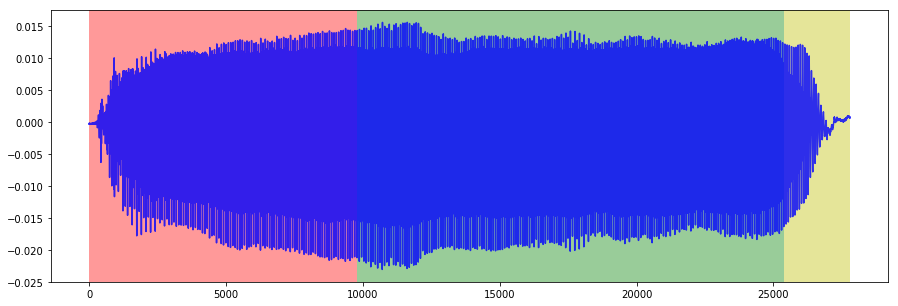

In [12]:
# State prediction on testing vowels
predict_voice_state(model_vowel, voice_te, feature_te, num_components)

In [ ]:
# save the results of mean and covariance for good states prediction
rep = 10
np.save('Stat/%s/%s_mean_%02d.npy' % (subject, vowel, rep), model_vowel.means_)
np.save('Stat/%s/%s_cov_%02d.npy' % (subject, vowel, rep), model_vowel.covars_)
np.save('Stat/%s/%s_cluster_%02d.npy' % (subject, vowel, rep), model_vowel.cluster_center_)
np.savetxt('Stat/%s/%s_mean_%02d.txt' % (subject, vowel, rep), model_vowel.means_, fmt='%.4e')

### 5.2 Using syllable1 as tesing voice signal

“afa afa afa ifi ifi ifi ufu ufu ufu”

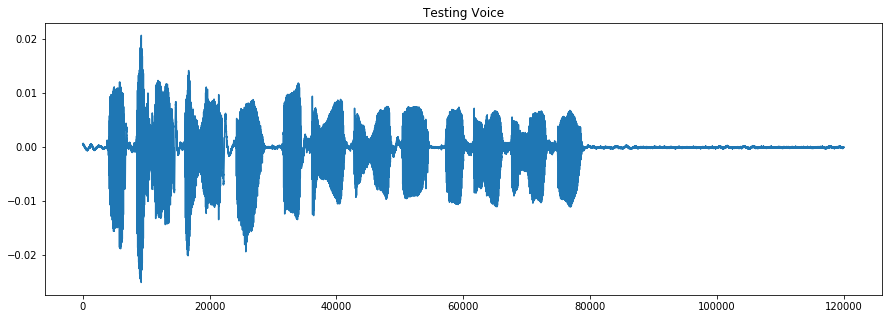

In [13]:
syllable = sio.loadmat('Data/%s/syllable1.mat' % subject)
voice_syl_te, feature_syl_te, length_syl_te = load_voice_testing(syllable, 0)

In [14]:
# Test the scoring function
f_i = 0
score = model_vowel.score_samples(feature_syl_te[range(f_i, f_i+120)])
print(score[0])

-8251.754482184251


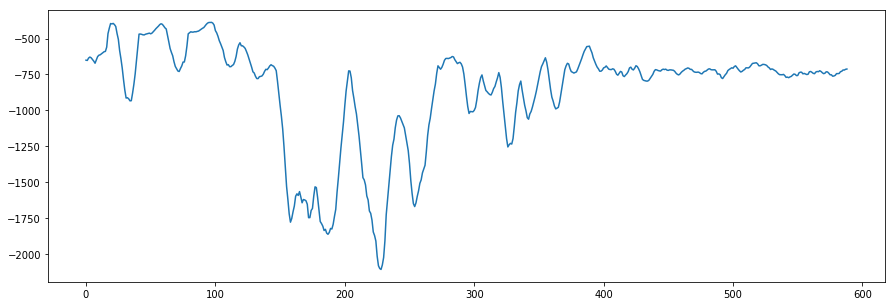

In [15]:
window_size = 10
log = []
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA38AAAEyCAYAAABK7mkUAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3XV4W/fVwPHvlWRbZma2Yyexw8wpw1Jmbrfy2q3vOuzawbutHRT2dqWVmZlSTts0nDjskJmZZFmWLEv3/UOWE8ckyZj4fJ6nz5NKV9LPtmzdc8/5naOoqooQQgghhBBCiOObZqwXIIQQQgghhBBi5EnwJ4QQQgghhBATgAR/QgghhBBCCDEBSPAnhBBCCCGEEBOABH9CCCGEEEIIMQFI8CeEEEIIIYQQE4AEf0IIIYQQQggxAUjwJ4QQQgghhBATgAR/QgghhBBCCDEB6MZ6AUMVERGhpqSkjPUyhBBCCCGEEGJM5OTk1KuqGjnYccd88JeSksK2bdvGehlCCCGEEEIIMSYURSlx5Tgp+xRCCCGEEEKICUCCPyGEEEIIIYSYACT4E0IIIYQQQogJQII/IYQQQgghhJgAJPgTQgghhBBCiAlAgj8hhBBCCCGEmAAk+BNCCCGEEEKICUCCPyGEEEIIIYSYACT4E0IIIYQQQogJQDfWCxDiWFZYZ6Sk0URHpx2z1cYpU6Px95FfKyGEEEIIMf7IWeoxqrK5nYgAH6pbzBjMVqbFB4/1kiaUprYOfv3Obr7eX9Pj9thgPf+5fDbzU8LGaGVCCCGEEEL0TYK/Y1BeTSun/d9afL20mDpsaBS47/zpXLYgaayX5pa8mlb++GEu9UYL1y1N4YoFSSiKMtbLGlSD0cKVz2ymsL6NX5ySyfLMCLy1GgztVu56fw+3v7adL3+xkmBfr7FeqhBCCCGEEN0k+DsGfXOgFlWFc2fFERvsS05JE797bw/hAT6cmhU91stzyZ7yFi55ciN6Lw1JYX7c/f5ezFY71y9LHeulDajTZuenr26nqL6N566dz7KMiB73P3L5bM5/fAP3fbqff140Y4xWKYQQQgghRG/S8OUYtPZQHVNiAvn7BTP4+ckZPH3NPLJig7jrvT00tXWM9fIGVd5k4voXtxLm783n/7OC93+6lNOyorlv9X42FzaM9fIG9I/PDrC5qJF/XDi9V+AHMCMhhEvmJfDhrgqsNvsYrFAIIYQQQoi+SfB3jDF1dLKtuIkVmZHdt3nrNDx4yUwa2yw8v6F47BbngvImE5c9tYl2q41nr5tHdJAejUbhwUtmkhjqy51v7cJgto71Mvv00a5KnllXxLWLkzl/dkK/xy2bFInZamdfpWEUVyeEEEIIIcTAJPg7xmwqbKDDZmf5UVmnqbFBZEQFsreiZYxWNrjyJhOXP72JlnYrr96wkCkxQd33Beq9+Pels6g2mPnFGzsxW21juNKeWtqt/PHDvdz55k7mJYdy96qsAY+flxIKwNbixtFYnhBCCCGEEC6R4O8YsyG/AW+dps9uklNjA8dttqnZ1MFVz2ym2eQI/GYkhPQ6ZnZSKH8+J5tvDtRy6ys5Y7DK3rYUNfKjh3/g1c2lXDo/kaevmYe3buBfm+ggPUlhfmwrbhqlVQohhBBCCDE4afhyjNlS3MisxBD0Xtpe92XFBfHBzkqa2joI9fceg9X1zWqzc9tr26lsNvP6TX0Hfk5XL0qmzmDmP2vyqWu1EBnoM4orPcxqs/Ofb/J47Nt8EsP8ePfWJcxK7H/dR5uXEsraQ3WoqnpMdDAVQgghhBDHP8n8HUOMlk5yKw0sTO17htzUWEcZ5f6q8ZP9s9tVfvPObtbnN3Dv+dOYmzz4/LulkxwlraNZwmq12bHbVfJrjTzzQyEXPL6BR9bkc8GcBD79+XK3Aj+ABSlh1Bs72F7aPEIrFkIIIYQQwj2S+TuGbC9pwmZXWTBI8LevysCSSb07UY42VVX526f7eX9HBb86LZOL5yW69Ljs+GAUBXaXt3DilKhhX9ee8hbufGsnWo1CVlwQFU3tbC91fG/tquOY5HA/Hrl8NmfPjPPoNc6aGccDXx7i3k/38e6tSyT7J4QQQgghxpwEf8eQrcWNaDUKc5JC+7w/IsCHyEAf9o1R5q+8ycTaQ/WUNLRxzqw4PthRwXPri/jx0hRuO3GSy88T4KMjLcKfPSOQ+Xsnp5zfv7+HyAAf4kN92VTQQESgD9cuTsHHS0NUoJ5Ts6KJC/Ed0usE+Oj4zemT+c27u1m9p5pVM2KH6SsQQgghhBDCMxL8HUO2lzaRFRuEv0//P7as2CByK4Y/+FtzoIZ3cyqwqyrT4oM5PTuaSVGBlDeZeH59Md8drKWgrg0ARYEn1xYCcPmCJP6wKsvtzNf0+GA2FQ5vt8z3d5Tzq7d3sSQ9nEcun014wMjuJ7xobgKPfJvH61tKJfgTQgghhBBjToK/Y0hVs5mpcUEDHjMrMYT/5OXRarYSqPcattd+em0Ru8qbiQr04bO91dz/xUEiArwxtHcCsCg9nMsXJLEyM5JQf2/e217OrMTQfktUBzM9IYQPdlZS22omKlA/LF/D5sJGwvy9eeknC9BpR367q0ajcMHsBP6zJo+K5nbih5hNFEIIIYQQYihGLPhTFOXPwI1AXddNv1dVdXXXfXcB1wM24Oeqqn7RdfsZwMOAFnhGVdV/jNT6jkW1rRZWDtL9ck5yKKoKu8paWJYxfPv+alvNnDA5ksevnEttq5lPdlWRV2vE31vL9ctTiQ3uGdjctCJ9SK83PT4YcDR9OWnK8AR/1QYzcSH6UQn8nC6ck8DD3+Tx/vZybj8pY9ReVwghhBBCiKONdObv36qqPnDkDYqiZAGXAdlAHPC1oiiZXXc/BpwKlANbFUX5SFXVfSO8xmOCqaMTo6Vz0NEHzq6U20ubhjn4s7A8IxKAqEA9P1mWOmzP3ZfsuKDupi8nTYkeluesbjGTEDq62bekcD8WpITx8a4qCf6EEEIIIcSYGotRD+cCb6iqalFVtQjIBxZ0/ZevqmqhqqodwBtdxwqgrtUCMGgJZLCvFxlRAewoHb4B42arjVbz4IHncPLvavoynOMeagxmooOGJ4vojlOzojlY00p5k2nUX1sIIYQQQginkQ7+blcUZbeiKM8piuJsURkPlB1xTHnXbf3dLjgc/LkSgM1JCmVHWTOqqg7La9canIHn6A5cn5EQMmwdP81WG00mKzFjEPydNNUxrmLNgdpRf20hhBBCCCGchhT8KYrytaIoe/v471zgCSAdmAVUAQ8Ow3qdr3uToijbFEXZVldXN/gDjgO1ra4HYDMSg2k2Walobh+m1zY7XnuUA6dp8cHUGCzUGsxDfi5nABsdPPrBX3pkAKkR/nyzX4I/IYQQQggxdoa0509V1VNcOU5RlKeBT7r+twI4ctp3QtdtDHD70a/7FPAUwLx584YnvTXOuZP5Swj1A6Cy2dz976FwJ/AcTs6mL3sqWjh5iIFndVcAORaZP4CTpkTx8sYSmk0dhPh5j8kahBBCCCHExDZiZZ+Kohw52Ox8YG/Xvz8CLlMUxUdRlFQgA9gCbAUyFEVJVRTFG0dTmI9Gan3HmtpWM1qNQpgLgUNcV3arqmWYMn9dgdNoB39HNn0Zqu7gbwwyfwAXzImnw2bnrW1lgx8shBBCCCHECBjJPX//UhRlj6Iou4ETgV8AqKqaC7wF7AM+B25TVdWmqmoncDvwBbAfeKvrWIEj8xcR4I1GM/iw9NiueXKVzUMvlwRH5k+nUQgd5YyVv4+O9MgAciuHHvzVtDi+F2PR8AUgOy6YBalhvLSxBJt96MlqVVW59ZUcfvX2rmFYnRBCCCGEmAhGLPhTVfVqVVWnq6o6Q1XVc1RVrTrivntVVU1XVXWyqqqfHXH7alVVM7vuu3ek1nYsqm21uDzsPMBHR5BeN3yZv1YLEQE+LgWew21aXBB7KwxDfp5qgxlfLy1B+pGebtK/Hy9JobypfVgav3yRW81ne6t5d3s5pQ3SRVQIIYQQQgxuLEY9CA/UtVrcGrUQF+JL5bA1fLEQFTS6JZ9O0+KDqTaYu/c8eqraYCYmWI+ijH4A63RqVjSRgT5DLv202uz89ZP9pEX4o1UUXtpYPCzrE0IIIYQQxzcJ/o4Rda0Wt/bcOYK/YSr7NJhHfb+f07Supi9DLf2saTETPUYBrJNOq+GCOfGsOVDb3UHVE5sLG6lobuc3Z0zhzOmxPLu+iHl/+0r2EwohxAhobOtgY0EDL24o5sEvD2K12cd6SUII4bGxq4ETLrPZVRraOtzK/MUG64dt0Htdq4XZSaGDHzgCsuKCANhb0cIJk6M8fp7K5nYWpYUP17I8dvHcRJ78vpAPdlRw04p0j57jy33V+HppOWFyJNPig0gM9WVrcSO/eWc3da0Wbjtx0jCvWgghJqYGo4VTHvqeJpO1+7bsuGDOmBYzhqsSQgjPSebvGLCv0oDNrpIa4e/yY+JCfGkyWWnvsA3pta02Ow1tHWOW+QvSe5Ea4T+kfX+WThtVBjNJ4UMfezFUk6ICmJscylvbylFV9xu/2O0qX+bWsCIzAr2XloRQP35zxhReu3ER58+O5/4vDvK2ZACFEGJYPPptPi3tVp64cg7f//oEIgN9eG97+VgvSwghPCbB3zHg6/01KAqszIx0+TFxIY7mMJVDbPpSb+ya8TeGJZPT4oPJKW3C7mGXzPKmdlQVksLGPvgDuGReAvm1RnaUNbv92D0VLVQbzJyW1fOqs5dWw78umsGS9HD++GEuLUdcpRZCCOG+0gYTr2wq4ZJ5iZw5PZbkcH/OmxXHtwdraWzrGOvlCSGERyT4OwZ8vb+GuUmhhAe4U/bpGPdQNcR9f3XdA97HZkQCwClTo6hrtZDjYRlraaOjG+Z4Cf5WzYjD10vrUYZuW4nje7A8M6LXfV5aDb//0VTarTbezpHsnxBCDMUDXx5Eq1H4xamZ3bedPzsBq03lw50VY7gyIYTwnAR/45iqquwqaya30sDJU6Pdemx816y/iuahjQGoNTiDv7HL/J08NRofnYZPd1cNfnAfysZZ8Bfgo+OMaTGs3lPtdunnwWoD4f7e/Qbj0+KDmZccysubSjzOlAohxES3t6KFj3ZVcv2y1B7zYbPigpiREMyrm0s9Kt0XQoixJsHfOFVvtHDlM5s597H1+Og0bm8ujwvxxVunobCubUjrqG0d+7LPAB8dJ0yOZPWeKo8GpJc2mNB7adxqmDPS5iaH0tJupcLNcRwHa4xkRgcOeMw1S1IoaTDxQ379UJYohBAT1lNrCwnS67h5Ze/GXFctSia/1sjmosYxWJkQQgyNBH/j0I7SJs5+ZB05JU3c/aOpfH3nSreavQBoNQppEf7k1xqHtJbaVjOKAhFulJyOhLNmxFHbamFTYYPbjy1tNJEU5jemM/6ONjXW0cV0f1Wry4+x21XyalqZHDNw8Hd6djShfl68tVVKP4UQwl0Gs5Uvcqs5d1Y8QXqvXvefPSOOIL2ON7aUjsHqhBBiaCT4G2de31LKpU9uQqtRePfWJdy4Io1ED8sV06MCyK8bavBnIczPGy/t2L5VTs2KJlCv450c97usOYO/8WRKTCCK4ujk6qrypnZMHTamDBL8+ei0nD87gS/3VUtTAiGEcNPq3VVYOu1cODehz/t9vbWcmhXD94fqpLxeCHHMkeBvnPhwZwXnPbaeu97bw8K0MD6+fVn3gHNPTYoMoKzRhNnq+biHWoNlXJRL6r20nDMzjs/2VmEwu97JUlVVyhpNHgfQI8XfR0dKuD/7q1wP/g7WOLKEmYMEfwCXzJemBEII4Yn3tleQFunPzIT+P4OXTgqnyWRlf7XnY4iEEGIsSPA3DryxpZQ73thJe4eNP5yVxQs/XkCov/eQnzc9KgC7CkX1nu/7q2s1ExU0dp0+j3TR3ATMVjuf7612+TH1xg7aOmwkho6v4A9gamygWycOB7uOHWzPH8CUmCCmxATymRvfKyEmMrPVRmGdUZp4THDVLWa2FDdy7sz4AbcKLEl3dFzekO/+VgQhhBhLEvyNMLPVxr8+P8Bz64ro6LT3ur+4vo3fv7+HFZmRfPyzZVy/LBWtZnj2pk2KDAAY0r6/2lbLmHb6PNKsxBDC/b3Z4sYm+9zKFgCmxA4eMI22qTFBlDSYaHUxk5lbaSApzI8AH51Lx5+WHcO24kYaumY1CiH6Vlhn5KxH1nHSg99z8oPfd3cIFhPP6j2OrtKrZsQOeFxMsJ60SH/WF0hjLSHEsUWCvxFktHRyyZMbefy7Av7yyT4ueGI9bZbOHse82TXr7f6LZuCtG94fR1qkP4riefBnt6vUjaPgT1EUZiWGsNON4ei7ylpQFJg+xBLakeAs691V1jLosXa7yqbCBhakhrn8/KdlRWNX4Zv9tR6vUYjjTVmjiU93V/HZnio+31vNDS9u5ZSHvqfBaOG3Z0yhormdR9fkj/UyJ4QN+fWsvP9b6sfRBapP91QxJSaQSVEBgx67ND2CLUWNQ9paIYQQo02CvxH05PcF7C5v4Ykr5/DYFXPYV2ngd+/t6S4r6rTZeSennJOmRPWYIzRc9F5aEkP9PG760mTqoNOujpvgD2B2Ugj5tUZa2l3Llu0ubyY9MoDAPjq2jbWFaWH46DR8vb9m0GP3VRloMllZOinc5efPjgsiPsSXL/dJ6acQ4JjddvKD33Pba9u59dXt3PJKDjvLWrh5ZTqr71jOrSekc+n8RN7bUU5Vi3tjWIT7Hv02n5IGE2vGyQWqiuZ2ckqaWDV94Kyf05nTYjB12Phsr2czaIUQYixI8DcCnl1XxENfHeLpHwo5e2YcZ06PZdWMWH552mQ+3lXJCxuKAfj2YB11rRYunZ80YmtJifCnpMGzPX+HZ/yNjz1/ALOTQgHY5UL2T1VVdpW3MGOATftjyc9bx/KMCL7aVzPoPqMNXaVFzn0mrlAUhdOyo1mbV98r4yzERGPq6ORnr+8gzN+bj25fyke3L+W1Gxay8a6T+O0ZU4gN9gXgphVpqCo8/HXeGK/4+JZX08qGAsd+uW8Pjo/g7/3tjm7S582Od+n4RWnhJIf78foWGasjhDh2SPA3Ajbk1/PImjxUFX592uTu229dmc6pWdHc++l+ckoaeXNrKZGBPpw4OXLE1pIS7kdJg8mjJgbdwd84yvzNSAhGUWBH6eDBX1WLmXqjhVmJIaOwMs+clhVDRXM7+wbp+rk+v4FJUQFuZ4hPy4qho9PO2kN1Q1mmEMe897ZXUFTfxoOXzGRGQggzEkJYMimi1xibhFA/frIslTe2lrE+X/ZzjZQXNxbjrdNwenY0P+TV97knfjSpqso7OeUsSgtzuTu0RqNw6fxEthQ1UjDEsUpCCDFaJPgbAc9eN589fz6dH357Iknhhz9ENBqFBy+ZSUywnl+8uYs1B2q5aG4CuhGcoZcU5keruZMmk+vjEZxqDWYAogLHT+YvUO9FZlQgOaVNAx73ye5KbnttOwAzEsZv8Hfy1Cg0Cny2p//SzBaTlU2FDSyb5HrWz2l+Siihfl58uW/w0lIhjmer91SRFunPkvTBS6fvPDWT1Ah/fvfebtosnVg6bXyRW83uctf3G4v+GcxW3ttewTkz47hwTgJGSyfbil1v5DUStpU0Udxg4qK5iW497qK5Ceg0Cm9uleyfEOLYIMHfCAnw0fUZNAXpvfjbedMobTRhV+GSee590LgrJdwfwKPSz8Nln+Mn8wewKC2MLUUNWDr73mSvqir3fbqf8qZ2zp0VR3Zc0Civ0HXhAT4sy4jkve3l2PoZFvzO9nIsnXYuntf3wOGB6LQaTp4azTf7a7DaxvbKuhBjpd5oYVNhA6umxw7Yvt9J76XlXxfNoLypnVteyWHJ39dw88s5XP7UJg51zdsUnntnWzmmDhvXLk5hyaQIFAW2Fg98Qc8dbZZO3t9RjtGNcvd3tpXj563lzGkxbr1WVKCek6dG8U5Oeb+fSUIMN5td5at9NTz01SFuemkbK/71LUv+/g3r8qRaQQxOgr8xcMLkKK5YmMQ5M+NIjfAf0ddK7so8lnrQuryu1UKgXofeSzvcyxqSFZmRmK12tvVzsrCjrJnKFjN3nTmFhy+b3ausa7y5ZF4ClS1m1ufX9+oaZ7ervLKphLnJoWTHebZ38fTsGAzmTjYXDt+VdVVVZR6aOGZ8kVuNXYUfudjIA2B+ShjXLk7hh7x6ksP9eOyKOfj56LjppW1jXqJ4LLPZVV7aWMycpBCmJwQT4KMjMdSPQ7XDF1Q/+OUhfvHmLpb/c41L2VpTRyef7qli1fRY/F0cpXOkyxck0djWwVdSYSFGyb8+P8CNL23j0TV5FNQZmR4fjL+Pjmue28yaA4ffh6qq8kNeHR/vqmRHaZNcBBYAuP9XTgyL+86fPiqv49y7UFzvfvBX22omchzt93NalBaOl1ZhbV4dS/sohVy9uwpvrYZTsqLHYHXuOzUrmhA/L65/cSteWg0f3b6MSVEBmDo6+cMHuRTVt3HHyRkeP//yjAh8vbR8kVvNsgz3S0ePZjBbue3V7dS1Wnjg4pndIyuEGK/eySlnUlQAU2Lcm/f5+x9N5YxpMSxICUOjUfDRabjhpW18ua+as2bEjdBqj29f5FZT3GDi16dP6b4tMzqAQ9XDE/zVGMy8urmEEydHsq2kiVc2lfCviwYu/f98bzVGSycXzXW/ugJgeUYkCaG+vLC+eNy+L1RVdSnrLca/r/fV8OTaQi5fkMSfzs7qvkBvtHRy0RMbuOu9PXx1Zxgl9Sb+8fl+1uc3dD82UK/jJ0tTuWVlOr7e4+vCvhg94zslIoZM76UlNlhPSaMHZZ+G8TPj70j+PjrmJoey9lDv8oZOm53Ve6pYkRlB0Dgc79AXH52W354xhdOyY/DSavj9e3sorDNy8X838t6Ocn520iTOmen5CYXeS8uKTEdXUXs/paWusnTauOLpTWwsaKDe2ME5j67j9tccgaAQ48FfP9nH797d3Z2Z3lvRwo7SZq5YkOT2ya+3TsOitHA0GsfjTpwSRUKoL69tLh32dU8Eqqry2Lf5pEX4c8YR5ZWZ0YEU1bcNS0b1qbWF2Owq/3vONFZkRvLdwbpBqxTeySknKczPrTmqR9JqFG5Ylsq2kqZB9y6+k1POnW/uHNXZgKqq8uMXtvKjh38gp2T4ymuF+zptdl7eWMxp//6ebw+43+W2rNHEL9/eRXZcUI/ADxzbjf510QzqWi3M/9vXnP3oOvZWGPjLudl8+YsVPH7lHJakh/PwN3n89NUcOiULOGFJ8DcBJIU5On66q7bVMq6avRzpxMlR7K8y9Crp+WhXJZUtZrc37Y+1yxck8dgVc7h71VS2FDdy0oPfU1zfxnPXzeeXp03uPvn01OnZMVQbzOyuGHyg/ED++10heysMPHrFHL6+cwU3rkjjq3013PnWTikDFePCJ7sreWNrGc+vLwbg1c0l6L00XOhhVudIWo3C5QuS2FDQQKF0d3TbtpImcisN3LwyDe0Rf9MyowPptKsU1Xs2lsjJZlf5cGcFp2VHkxTuxwmZkdS2WgbsplzeZGJDQQMXzU0YUmbs0vlJhPl78+i3+X3+LbTZVV7eVMKv39nFezsquOeDvSPyN7PN0slTawvYV3n4a/5mfy3fHayjpKGNy5/aJO/dMfSHD3P5w4e5lDe1c8cbOyhzY0tOdYuZm1/OwW5XefzKOX1uyZmREMITV83l6kXJ3LNqKut+eyLXLE4hMzqQH02P5cmr53Hf+dP59mAdv3x7l4yBmqCk7HMCSAn35xs3rzCpqkpd6/jM/AFcsTCJp38o5G+f7OfNmxehKAqdNjv/+SaPqbFBnHaMlHwe7eK5Cfh762hss7B0UgRpkQHD8rwnTXF0FV1zoNbj0Rf5tUYe+y6fs2bEdl+1v+vMqSSE+vGHD/by6uZSrlqUPCzrFcITLSYrNQYL/t5a7lu9H72XlndyyrlobiLBvsNTCXDOzDju/+Ig6wsahu33c6L4Ia8ejQJnTOu59zIz2lGOe6imlcluluYeaXORoyLBWXq5smuM0ncH6/rdM/1uTgUAF8xxbbZff3y9tdyyMo37Vh/gnZxyLj6imVtdq4VLn9xIYX0bS9LDmZEQwn+/L2B6fDDXLkkZ0useqbrFzAWPr6eyxUxyeClf/M8KdBqF+784SEq4H6/ftIjTHlrLXz/Zx/M/XjBsrzuaVFVlXX49z60rIiLAh0vnJzIvxbOM7Wj5el8N9322Hz9vLXsrHBc/rlyQzKpHfuC217bz9i2L8dH1DuQ6bXbueGMnP+TV4eutxWh2BGqPXjmH5PD++0Wcnh3D6dn9Ny66YmESjW0WHvzqELmVBt65ZTEhft5D/0LFMUOCvwkgMcyXeqMFs9XmcvMWo6WTdqtt3HX6dArUe/GLUzO5+/29fJFbzRnTYvl0TxXFDSb+e9XcIWfKxoqiKKya4XpTCleF+HkzMzGEtYfquPPUTLceu/ZQHaaOTh748hABPjr+eFZWj/uvWpjE6t1VPPTVIc6fHe9RwwQhhoOzach9F0zn/i8O8vv39xAR4MOvT588yCNdlxDqS5Bex/5BZnOK3jYVNDAtPrhXIJ4W6Y9GYcidVD/dXYWvl5YTJ0cBjk6c0+OD+WxvFbedOKnX8Xa7yrvby1mSHk5CqGuz/QZy/bI01hyo5Y8f5rIoLbx7z/0/PjtAWZOJR6+YzZnTYlGA/NpW/vrJPqw2O7OTQjlU08qT3xeQFhnAz0/O8Ogi3etbSqkyOJqd/f2zA9y3ej+Beh0Ha1r571VziA325ecnZ3Dv6v2sz6/vc8+8q1rNVgJ8dL2ypTa7yie7Kymqb2NKTBD7Kls4YUoUc5JCPX4tpx/y6vjHZwfIrTQQHeRDe4eNd7eXc+sJ6UyNDeKUqdEeN6jbUdrEg18eoqi+jVOzovnNGZPx8x7aZ1mLycqfP87l/R0VZEYHYO1UOWVqFL8+bTI6rYYHLp7JzS/ncO+n+/nLudN6Pf6BLw/x6Z4qzp0Vh74rOLxheSoZ0Z5fIHG6/aQMZiaG8JMXtnLTSzn4+WgJ1Htx+YJElqQPvTfA8cjU0cmbW8vYVtJEVmy5cx+oAAAgAElEQVRQn39TjhVyljYBxAT7Ao6rgikudhc9POB9fJZ9Alw6L5EXNxTz988OcOKUKJ5bX0xahP8xm/UbaSszI3n4mzya2joI9XftKt+BagM/eWErnXYVjQIvX7+QqKMGzSuKwq/PmMwFj2/gpY0l3HpC+kgsX4hBOYOHeSlhPHHlXO54Ywd/OiebMBff765QFIWsuKAeZXVicO0dNnaUNfGTpam97tN7aUmJ8B9S8KeqKl/k1nDSlKgejSwunpfAHz/MZVdZMzOPCqjWHKiltNHEr4bp4oBWo/DQJbM46cHveODLgzx82Wy+O1jbHaAc2QzmoUtncc2zW/jbp/u7b5seH8zu8mZ+8sJWvr5zpVvvW1VV+WBnBYvTwrl5ZTplTSZe2lgCwIVzErqzrdcsSeapHwp55odCj4O/Z9cV8ddP9hHu783ZM+O4ZnEyaZEBNBgtXPv8FvZW9PzdePy7Aq5enIyft5bP91ZjttqJCPQhMyqA7LggLluQNGDQpqoqr24u5U8f5ZIc5se950/jorkJdNpUfv3OLh77tgCAEydH8vQ189yenfzWtjLueX8v4QHeZMcF8cKGYl7aWEywrxc2u4rVpnLOzDj+fsF0ly8s59W0cv2L26hsbueOkzO47cRJeOt6ruv07BhuXJ7K0z8UMTU2iMsXJAGOZnu/f28vX++v4fIFSfz9gpFpELg8I5I/n5PN3e/vJTZYj9lq4+NdlVy9KJlfnTaZYL9jo28CjFxDI1VVeeL7Atbl1VNY10a1wUxCqC/px3jVhwR/E0BcsONkvbKl3fXgz+AM/sZn5g8cM+zuXpXFtc9t4aaXcthV1sxfzs0+ZrN+I21FZiT/93Ue6/LrOduFBjJ2u8pd7+0hyNeLBy6egd5L2+8VwTlJoazMjOSZHwq5ZWWadJXrQ0ennSue3gTA1YuTOXfW0MrMRG+HqlsJ8NERF6wnPsSXNb86YUReZ2psEG9sKcNmV3vsXRP9yylpwmpTWZQe3uf9aRH+Hu1Nd6ozWqg3Wpib3DPDdP7seP752QFe2ljCg0cFf0//UEh8iK/bs/0GEhfiy/XLUnns2wJ8vbS8u72cydGB/OyknlmCIL0XH9y2lOL6Ngrrjei9tCxOC+dgTStn/Wcdf/t0Hw9dMqv7eJtdZUtRI3OSQ/osEdxe2kxJg6k7G/HXc6exIiOStXl1/O7Mqd3H+ei0XL0omYe+OkRBndHtk9ickkbuW72fRWlhRAbqeWVTCS9sKCY+xHGRud5o4eHLZrEyM5JDNUaSw/34yyf7eHljCTZVZWl6BNFBeqpa2vn2YB1v55Tz4a5KnrlmHuEBvc83Wtqt/PKtnXy9v5YTJkfy2BVzuqtLfHTw2BVzqDaY+XxvNf/78T5+8dYu7r9oxqAZwE6bnY93V/LN/lo+2V3FskkRPHL5bEL9vdlW3MjaQ3U0mjrQaTQ0mTp4c1sZgXod9xxV+dIXs9XGlc9sxq7CW7csHjDr+dszpnCoxsgfPthLiK8XiWF+3PxyDg1tFu46cwrXL+t9sWQ4XbkwmYWpYaSE+9NpV7n/i4M8u66ID3ZW8M8LZ7g1HmcktHfYusvBj/6Z1hstVDa3U9Vi5u739zIrMZi7V2UN2wi1WoOZR9bk8/KmEqbEBJIRHcCjV8we92XGrhix4E9RlDcB5+W0EKBZVdVZiqKkAPuBg133bVJV9Zaux8wFXgB8gdXAHap0kRiymK7gr6rZ7PJjalsdx47Xsk+nlZmR/HhpCq9sKiHEz4sL5wy9qcPxamZCCMG+Xry5tYzTs2N6XYU82pf7qtlR2syDF8/kpCmDZ1NXZEby/aE6mkzWYc20HC/KmkxsK2lCo0CruVOCvxFwqMbIpKiAEb/4kBUbRLvVRklD27jY92e22vDWasb1ha/NRQ1oNQrz+zlxSgzzY0NBg8dX8PNrHU1MJkX1/HkE6r24YE4Cr24uQauBX3U10HphfTGbixq5Z9XUYZ8Fe8vKdD7dXcVHuypZNimC/7tsdr8lhCkR/j0uyk6JCeLGFWk88V0BN69I794D+eCXB3n8uwIiA3144so5vU5An1tfhN5L0x3IKorCadkxnNbH3q8rFibx6Lf5vLyxhD+fk+3W1/aXT/YTE6TnyavnEezrRdWPpvDVvho2FzZS1dLOvy6a0Z1RdHZPfeyKOXR02mnvsPXKJn2+t4o73tjJra9u5/UbF/W4mFLXauHqZzdTUGfknlVT+fHS1F4XWxRFITbYlx8vTcXSaecfnx1gf5WBEydHEurvTVWzGS+thnNnxXVnfhuMFm57bTubChsJ9NFxy8p0fnVaZnfGcF5KWI/vr6qqBOp1PLOuiMsWJPV6jx3t7W1l1LZaeP3GRYOWu+q0Gh69YjbXPb+Vn762HVWFiAAf3rp5MTMSPNuf765JUYFda4E/nJXFhXMSuPuDPfz89R34eWs5oauMejhtKmzgy9waAvQ6rl2c3Gfg//2hOm56aRuWTjupEf48cPFM5iaHYrer3PPhXt7aWkZnVwfz9Eh/NhU2cu6j63jxJwuYnRSKqqo88OVBXt1cSkKoL/eeN71X9r8/q/dU8bPXd2Czq/x4aQp/PCvruLqoPWLBn6qqlzr/rSjKg8CRbQYLVFWd1ftRPAHcCGzGEfydAXw2UmucKGKdZZ8G14M/Z+v+yHFc9un0p7Oz+flJGZg7bbLfbABajcIvT8vkjx/mcvtr23ny6rkD/jF7+ociksL8OG+2a0FKfEhXhrm5XYK/Pji7ui1MDWdzUQPtHTaZszTMDtW0csrUkS/7nhobBMC+KsOYB382u8rJD37PJfMSueMUz+eBjrRd5S1kRgcS0M/f6KQwP0wdNhraOojo40RwMAVdwV9GdO+fx2/OmIxOq/DqplJW76nGarNj6bRzRnYMVyxMcvu1BhOo9+K7X5/o8eNvWp7G8+uLeOaHQu6/eCY5JU389/sCTpkaxa7yFh77Nr9Hw5b1+fV8uruK/zklg0AXRhxFBPhwytQoPtldxR/OynI5e72rrJldZc38+eys7n2bscG+XLM4hWsWpwz4WG+dps8LjmdMi+XvF9i4861d/PurQ90luJZOGze+tI2SBhPPXTef5RmRg67vlpXppEb48+T3BbywoRirTSXQR4fFZue59UXcvDKNm5ance3zW8irMXL/RTO4cE7CoBdNFEXhF6dk8va2cp5dV8jfL5jR77FWm50n1xYyJymERWmuZYgC9V68cv1C7l29j5ggPVctSh7TBixZcUG8+JMFXP7UJm55JYdXrl84rNmuv3y8j+fWF+Gj09Bhs7Mur45/XjgDg7mTOUkhKIqCza7y10/2ERfiyy0r03hkTT6XPrmR35wxmYa2Dl7bXMoVC5NYPimCVksn58yMo95o4cpnNnPlM5v5w1lZFDe08eT3hazMjCS/1shVz2zmpesdgWFf6o0W2iydlDW285t3djMtPpgHL545aLB/LBrxM2XFcXZ5CXDSIMfFAkGqqm7q+v+XgPOQ4G/IfL21hPp5Udnc7vJjalst+Og0BOmPjWDK1T1sE901i1NoMVl58KtD7Klo6ffKYk5JEzklTfz5bNdPDOJDHM0NypvaZfB7H8qaHL9/Z0yLYWNhAweqDf1+CAn3NZs6aGjr6PPkf7hlRAeg0yjsqzSM+VDv/VUGKprb+Wxv1bgN/lRVZW9FC6dM7T+DkNTVHKW00eRR8JdfayTAR0dMUO8LloF6L/50djbXLE7hoa8OEajXcf2y1HG7byfU35tL5iXy+pZSbliexi/f2klssC//vnQWj36bz7M/FHXv3a5qcZyoJof7cctK1/dbr5oex+o91WwuanC5wcdLG0vw99YOy9iUI10wJ4GNBQ08+m0+ZquNW09I548f5bKzrJn/XjXHpcDPydnpUlVV2q02fL20GC2d/OOzAzz5fSFPfl+IRoGnr5nHyW5cKAoP8OGiuQm8va2cPRUtzEsO42cnTeqRsVJVlbvf30N5Uzt/OTfbrUyRr7eWv503Mnv7PBGk9+LFnyzgkv9u5Lrnt/K386Zx4mTHftp6o4XCujYWpYUNuL/SbLVx/xcHMZo7WTUjlhWZkRTVt/HChiIunJPAvedP45v9tdz22nZO/fdawJHBu2ZxCpUt7eTXGnniyjmcOT2WM6bF8j9v7OC+1QcAuGB2PPeeN63H9zgh1I+3b17M7a/t4K739gCOsu8HL55JTauZS5/cxI0v5fDJz5Z1V8Q5fZFbzU9f3Y6tK5MY4ufFY1fMHpZGUOPRaJzZLwdqVFXNO+K2VEVRdgAG4B5VVX8A4oHyI44p77qtF0VRbgJuAkhKGv6rdsejmGBfqltcz/xVNrcTG6w/rtLcwuHapSk89l0+b2wt6zP4M3V08rt3dxPu792jXflg4kMdGeYKNy4yTCTljSa8tRpOmhLFnz7KZW+lBH/DqbwruB6ND2sfnZbkcL8hz6UD+L+vDxGo9/J4b8/mIsdQ8QPVrdQYzET3EfyMtcoWM41tHUwf4KKQM/grazR51Bkyv85IeqT/gJ9ZqRH+PHL5bLefeyzcuDyN97ZXcObDa1GB129cRKDei3NmxvHk94Ws3lvFj6bFcuXTm2lpt/LqDQvd6nR50pQo/Ly1fLK7yqXg70C1gY92VXDZ/CSXsovu+seFjn16z6wr4tn1RQD87swpvcaCuEpRlO5S20C9F/eeP51VM2JZn19PdlywW4Gf0y0r09lXZUCv0/LyphI2FNTz+R0rujOHT64t5K1t5fz8pEkubZUY7yICfHjlhoXc/tp2/ufNnb3uP2VqNI9eMbvP953BbOXGF7exuaiRIL2ON7eVcc+qqewoa8ZLq+G3Z05G76Vl1YxYzNaZGLq6x768qYQ/fZQLwPKMiO6xUsG+Xjx33XxyKw3k1bY6uub28bseFaTntRsXsuZALWmRAd1Zu9hgX565dh7nP7aepf9cQ1SgD09fM49p8cEcqmnl12/vYmpsID9ekkqovxczEkI8ugh1rBhS8KcoytdAXzul71ZV9cOuf18OvH7EfVVAkqqqDV17/D5QFMWtonNVVZ8CngKYN2+e7Al0QVywnko3gr/ypvbuNtXi+BKk9+JH02P5eGcl96ya2v0BWdHczrbiRl7ZVEJ+nZGXfrLArTLaUD8vfL20bmWYJ5LypnbiQ31JCPUlxM+LfZUtgz9IuKy8yVFWm9B1EWKkxYf6DflCR36tkYe/ySMh1Nfj4G9TYQO+XlrarTbWHqpz64LNaNlT7nivD1QR4AzaSz1s+pJfaxzS6ILxJjHMjw9vX8qv397FyswoFqU5GuVkxQYxKSqAx78t4O1t5ZQ3t/PqDQtd3svk5Out5eSp0Xy+t5q/nJM9YAbHarPzq7d3EezrGLE0ErQahb+eN41zZ8Xxye4qTpkazbKM4f15LkmPGNIYg8QwP97/6VIA3s0p55dv72J9QT3LMyLZV2ngwS8P8qPpMSP2PRoLcSG+vHXzYlbvrabWYO7ertBhs/Ovzw/ym3d28/Bls3oEYiUNbfz01e0crG7l4ctmcXp2DLe9ur27s+0Ny1J7dJI/MpN80dwEDta04uulJSnMr8fzKorCtPjgQSuLdFpNn3tdM6MDefmGhXyRW83HOyu57vmtZMUFsS6vjkC9F49fMZek8Ilx3juk4E9V1VMGul9RFB1wATD3iMdYAEvXv3MURSkAMoEK4MhagoSu28QwiAnWk1Pa5PLx5U3tA5boiGPbFQuSeG97BS9ucIxmeGtbGb95ZzcA0UE+3HvedLdKbcDxhzkuRE9FkwR/fSlrMpEQ6uv4AIsL7tUOXQyNM/Pn7Do40uJDfMmtGFoA/+iaPFQVyhrbqWu1EOlmd2W7XWVrcSNnzYjlu0N1rM2rH5fBX25lC1qN0r1Xsi++3lqiAn0obXQ/+DOYrdQYLMfd3pz0yADe6wo2nBRF4V8XzeDnr+9gZ1kzD182q98mOoNZNT2Wj3dVsrGwYcC/9098V8DeCgP/vWrOiO/nPrrZynh11sxY7lu9n5c2lrAgNYw739pJiJ83fztv+nFXMaXTajinjw7hdrvKA18ewkenwcdLw8lTonltSylf7atB76Xh6Wvndc/c/O/Vc1mfX4+3TsOi1L47/oLj/T0lpv+/E0M1JymUOUmhXDQngZtfyaGmxcyNK9K4YVma239/j2UjXfZ5CnBAVdXuck5FUSKBRlVVbYqipAEZQKGqqo2KohgURVmEo+HLNcAjI7y+CSMuxJdmk9WlJhNmq416o2XUrqCL0TcvJYxTpkbx6Jo8psYG8r8f5bIgNYy7fzSVafHBHrevH45syPGqrNFEdlcJU3ZcEM+vL6bTZnd7JpXoW0VzO/7eWkJGaTZVQqgvDW0dmDo6PRoG3WC08NGuSuanhLK1uImdZc2c6uaM0gPVrTSbrCxKC8fcaWd7iesX+EbTnooWMqICBi1LTArz8yj4czZ7mTRO9/ANtzlJoXzxPysoqm8b0v7qEyZH4u+t5ZNdVf0Gf/sqDTyyJo9zZsZ5XIJ5PPLRabl0fiL//b6A657byoHqVp67bt6EanZ26wmT2FTYyDvby/HRaXhlUyl+3lruODmDyxYkdjcbBPDSakaka6inMqIDWfPLE8Z6GWNmpM86LqNnySfACmC3oig7gXeAW1RVbey676fAM0A+UIA0exk2zk3wVS2Dn5iP5t4ZMXbuWZWF1aZy3fNbURSFhy6ZyczEkCHNLYsP8ZWyzz4YLZ00mawkhjk+DJPC/eiw2ak3dozxyo4fFV1ltaN11d15cczT93tOSRN2Fe44OROdRmGHG5UZTl/vr0FRHHtjUsP9qGppx2qze7SekeJs9uJKkJIU5tfdFdcdef2MeTie+fvohtxYS++l5dSsaD7PrcbSaet1/+FyT2/+182REBPBLSekc1qWo4HXpfMSj4t9fu7QahSe//F89v75dLbdcyqPXD6br+5cyS9OzewR+InxZ0Qzf6qqXtfHbe8C7/Zz/DZg2kiuaaKKDXEGf+ZBW5M7MzeS+Tu+pUT48+nPl3GwppXsuOBhCfad2RAZY9CTcz9aYtf3OLprv0ONwdyr65jwTEVz+6iVfMLh8tKypvbuOVnuyCltwkurMC8llKy4IHaUNrv9HF/kVjM7MYSoID0JoX7YVcc81/G0b6XaYKbeOHCzF6fEMD/e31mBpdPW5yDz/hTUGvHWarqbxgjXXTg3gQ92VnLVM5u5Z1UW0+OD0WiU7hlp+6oMPHX1XOmo3YcgvRf/vXou+6sME+rCw5G8tJruOZln91EaKsanY6OPvxiyhK42/K7sxzrcOEE+SI93GdGBZES7f+LaH+cJcUVz+4T9MOxLWaPj987ZRMnZkbHGjdmbYmAVze3MThqdochw+O+jp3tct5c0MS0+GL2XltmJIbydU+5WGXB5k4ncSgN3nTnFsZ4wZzBqGrbg79E1eSxOD2dusud7sFxp9uKUFOaHqjq+p+7MT8yvNZIa4S8l1B5YnhHJw5fN4nfv7uHcx9YT5u/NnKRQ6lrN7Cpv4eK5CX02zxCHDbSXVYjxSP5SThAxwXo0CpS7UKJU3tSOl1YhagJtfhXDIy5kaKVwxytnKZszmx4d5Pjdqmm1jNmajidGSyfNJmv3rMnREBXog5dW6S6Td0dHp51d5S3MS3aMNJifGoapw8auctcbyHyZWwM45prB4ayyJ2WTfcmvNfLAl4d4fUvZkJ5nb0ULGsXRpXIwzqDV3X1/+XVGudg0BOfOimf9707i/y6dxcrMSEob27DaVO49fxr/vLD/geZCiGOTZP4mCG+dhuggfXdWbyDlTe3Ehfh2z64RwlWxXSWM7syUnAjKmkz4emkJ7yqdCg/wQaNAnWT+hoUz+xY/iqXqGo1CbLCvRw2Ocitb6Oi0M7cr+FuaHoGiwLq8+u7bBvPtwVomRQWQEuEPOH73tBqFMhf+xrviw52OZttDnWW4t9JARlSgS2XgR876c5XZaqOs0cS5s/ocCyxcFObvzXmz4zlvtnwfhTjeSeZvAkkI9XXpKnV5V0t6IdwV1ZXRqpagpgfH3MzDzUi0GoWIAB9qDJL5Gw4VzaM7488pPsSXCg+Crd1dGb5ZiY5AL9Tfm+nxwazLr3Pp8aaOTjYXNnJC5uEOjTqthrgQfXeJ8VCoqsoHXcFf8RCDvz0VLWTHu1YWFxngg49O41bmr6i+Dbs6sZq9CCHEUEjwN4EkhPq5tD+lrNHUvUdQCHf46LREBHhTJZm/HsoaTd1leU7RQXpqWuX7NBwKah0BSkq4/6i+rqsX1I52oNpAmL93d/kvwLJJEWwvbabVbB308ZsKG+iw2Vk5uWd7/oQQv2HJ/O0ub6GssZ3J0YE0tHVgcGFNfakxmKlrtbjU7AUc2dREN8c95E+wMQ9CCDFUEvxNIPEhvlQbzHQO0ArcYLZSb+wgNXJ0T6LE8SMmWE+1CyNFJgpVVSlvau+VlYoOkszfcNlXZSAmSD/qM7ZiQ3ypM1rcHq+wv6qVKTGBPcZSLMuIwGZX2VTYOMAjHb47WIevl5YFqT0bsSSGeRaMHm1719iJKxclAZ5n/5zNXlwN/sA568/1ryG/1oiiQJp8ZgkhhEsk+JtAEkJ9sdnVAUvynB/yo30FXRw/YoL0kvk7QrPJitHS2d3p0ykqSE+tlMcOi9zKFrLjRr/jXmywHlV1r2ur3a5ysLqVyTE9u+zOTQ7F10vLuryBSz8NZiur91SxdFJ4r3EIiaF+1LVaMFt7z2xzx+7yFqICfViUFg54vu9vj7PZixs/G+esP1VVXTo+v9ZIUpjfoAPkhRBCOEjwN4E4W5MPdGXY+SEvV1GFp2KC9TLC4AjO37ejR6dEB+ppaOugo3N8DeU+1pitNgrq2twKMIaLJw2OShtNtFttTI3puV4fnZaFaWH8kFc/4OPv//wgjW0d3HFyZq/7nOMePGlCc6Td5c3MSAghKcwPRfE8+MutbCE9MgA/b9d7yyWG+WG0dNJkcq3UNL/WKCWfQgjhBgn+JhBnJ7zBgj9FQYblCo/FBvvSZLIOOftwvHDuwUoM6132CVBnlNLPoThY3YrNrro0SmC4dY82cSP4O1BtAGBKbO/5mssmRVBY39Zv8FbS0MYrm0u4ZnEK0xN6l1JGBTqC0bohjBBpNVsprG9jRoJjBmFcsK/nZZ8VLW6VfMLhzx5X9v112uwU1bdJsxchhHCDBH8TSFyI48RgoKYvRfVtxAX7SgmN8FhMkIx7ONLhGX+9G76ADHofqn1VjmAqO869IGM4xHRn/lzPtO2vakWjQEZU7+BveYajgUt/pZ8f7qwE4OaVaX3eH9k1m3Uowd+eihZUFWZ0BZepEf4eZf5qW83UGCxkuxn8JXfN+nMl4CxraqfDZiddgj8hhHCZBH8TiI9OS1ywnqJ6Y7/HFNe3ScmnGBLnCbHs+3Mob2onSK8j2Nerx+3OsRhVzfJ9Gop9lQYCfXRjMp4mSO9FgI+OSjd+hnm1rSSH+/c59y4zOoD4EF8e/Ta/18UT5/iFBSlhxAb3/bVGBgxD8NfVpGVGQgjg2AJQUNfm8h48p70V7jd7Acd+c61GIa+2ddBjuzt9SvAnhBAuk+BvgkmPCiC/ru/gT1VVCuvbpNmLGJLubIhBOn6CIwh2lgceKbVrOLfzBFZ4Jq+2lUnRAWg0yuAHj4DYYD1VbmT+iutNpIT3XVavKAqPXzmHpjYrVz+7uceIhdxKA4V1bQMOMw/29UKnUagfQilxcUMbEQHe3Z1TM6MDMVo63SptBdhZ5mj24m4jHm+dhpRwP/JqBv+9kOBPCCHcJ8HfBJMRFUh+rRG7vfdV3Ia2DlrNnd0npUJ44nDZp+xlA6g3WrrL8Y7k560jKcyPQy5kOET/iutNY/o3yzHaxLXASFVVShtNJA9wgW1mYghPXTOXovo27nh9R/donlc2leCt03DmtJh+H6vRKEQE+Awp81fVYu6RWcyMdpSnHqpx732aU9LI1Ngg/H1cb/Zy5Gu6clEkv9ZIVKAPQXqvQY8VQgjhIMHfBJMRHYDZau+zoUBB14etlH2KofD30RGk18msvy71RgsRAb2DP3CU+eW5eVItDjN1dFJtMJM6htUKccG+LmfFmrrGfgzWUGtJegT/e2423x6s45ZXtpNf28q728u5dF4ioYPMMowM9BlSE6GqZnN39h4c71HArfdpp83OztJm5iaHerSGjKgAihvaBm0alV9nlKyfEEK4SYK/CSaj64Oyr6uqziu7R8+fEsJdMcEy6w8cmR5H8Nf3CXtGdCBF9W1uDwkXDsX1jmY6qWN4wSomWE+90eLSyI6SBkcTE1e6KV+5MJm/nJvNNwdqOOWhtahq/41ejhQZONTMXztxRwR/IX7eRAb6cMiFMkynA9WttHXYPA7+JkUHYlcHHjGhqioFtcbuzzQhhBCukeBvgnFeJe1rM/3BmlYC9brusj0hPBUT7Eu1dLGkrcOG2WofMPNntaket9Kf6Iq7gqmx3KccF+L6oHfn+ILkfvb8He2axSm8d+sSrl6UzN2rpvbqGNuXyCGUfbZZOjGYO4k5qqGMuxnq7aVNAEPK/AHkDVD6WW0wY7R0SuZPCCHc5H4xvjimOa/i5tUYUVUVRTncJOFQtZHM6MAetwnhidggPQe6WvBPZPVdJ+Hh/QR/znb/h2qMZERLxt1dzsxQyhju+XPuj6tsbidxkIxeaYNz5qPrc1RnJ4UyO8n1ICoy0IeGtg7sdtXtJjjObL1zLJBTRlQgb20rc/k5txU3ER3kQ3wfjY5ckRbpj0YZuNTUWb0iYx6EEMI9kvmbgCZFBvDejgqm/ekLPtxZAThKaA7VtnZv7hdiKGKC9dQZLRO+nNHZdbG/ss9JUQFoFPebaQiH4vo2ogJ9CPCgqchwcY6Y6G8w+5FKGk1EB/mM6BzVyEAfbHaVJlOH2491Nq45uk/CAN4AACAASURBVPojMzoQU4fNpa9RVVU2FTYwPyXM4wuJPjotk2OC2FTY0O8x0ulTCCE8I8HfBHTZgkROyIxkckwgd7yxk/d3lFPXaqHZZGVytHyQiqGLCXaUwtUOYe/R8eBw8Nd35k/vpSUpzE/GPXioqL5tTLN+QPcYj/KmwQOj0gYTyWEju17ne82Tpi+VXU2ajp4j6Gz64spFisL6NmpbLSxJj3D79Y90enY020qaqG3tu5w2v9ZIkF7XPdtQCCGEayT4m4DOnRXPs9fN5/WbFjE/JZQ/fZjL+oJ6ADKl2YsYBt2z/iZ4x896oyP70teoB6e0yAAKZc+fR4ob2sa00yc4AvioQB/Km0yDHlvS2EaSi/v9POV8r3my78+Z+YsO7vl+zYg+XJ48mA0FjmzdkvRwt1//SGdOi0VV4Yvcmj7vz691dPqUbQpCCOEeCf4mMB+dln9cOAOz1c6db+0CYLKUfYphENsV/E30jp/OzF/YAO35UyP8Karve/am6J/BbKXe2DGmnT6dEkJ9B838tZqt1BgsIz6TcCjBX1VLOxEB3vjoepalBvt6EROkd6npy8aCemKD9S43telPZnQAaZH+fL63qs/7C2TMgxBCeEQavkxw6ZEBPHzZLLaXNjE9IaTfxhRCuOPwoHcJ/kL9vPDS9n+dLS3SH7PVTpXB7HGDjInI2SF1LDt9OiWE+rGzrHnAY5wlk1NGuLrCGfx5UnJd1dJzxt+RMqIDONRHl+gj2e0qmwobOWFy5JAzcoqicGpWNM+tK6LN0tljWHxTWwf1xo7uhklCCCFcJ5k/wZnTY7l7VRbnzIwb66WI40Swrxd6L40Ef60d/e73c3JmgorqpPTTHc5OnyOdSXNFQqgvlc3t2AbI3h6sdpRMjnRTrQAfHQE+OpdGTxytqtnca7+fU2Z0IPm1xoG/xppWGts6WJw2tJJPp2WTIrDaVLYUN/a43RloZ8cFDcvrCCHERCLBnxBi2CmKQmywL1UTfNafY8D7wMFfeqSjdK2wXpq+uKO43oSiuD4zbyQlhPrRaVcHDLgOVhvw99Z2dwcdSVFBPm4Hf6qqUtZkIrGfWYKZ0QGYrXbKGvvf2+jc77d4iPv9nOYlh+Gt1bAhv77H7ZuLGvHSKm6NwBBCCOEgwZ8QYkTEBOkl82e0EDFAsxeAqEAf/L21FErmzy1F9Ubign1HdGyCq5wB3UD7/g7WtJIZMzpzVD353as3dmDqsJEU1ndwerjpS/+lnxsLGkgO93NpGL0rfL21zEkOYX1+z5EPW4sbmRYfjK/32P/shRDiWCPBnxBiRMQG66lyYS7Y8azB2NHvjD8nRVFIjfSXjp9uKmowkRIx9lk/ODL46zsrpqoqB6tbR3y/n1NMkJ4ag3t7/kq7Mnr9dSPNjA5Eo8DeSkOf99vsKpuLGoat5NNpaXoE+6oMNHQ1TzJbbewub2ZBatiwvo4QQkwUEvwJIUZEXIgvNa0WOifooHdLp41WSyfhA3T6dEqLCKBAZv25pbi+bVzs9wPHe11RoKSh7+CvzmihyWQd8f1+TtHBempbzW51kHWWcyaF9R38BfjomBITRE5JY5/3761oodXcOWwln06nZEUD8Na2cgBySpqw2lQWpEjwJ4QQnhhy8KcoysWKouQqimJXFGXeUffdpShKvqIoBxVFOf2I28/oui1fUZTfHXF7qqIom7tuf1NRlMHPmoQQ41JciC82u0rNBB303myyAhDqQvCXGR1ARXM7RkvnSC/ruNDU1kFLu3VcdPr8//buPLrN+77z/ftLAgTABQT3RYslW7Jky7FlR07sxMmkzuZ00jjN6o6b+raZ8bST3NtO2qbp9N6Z257mnObOmabTk0560rpp0iZNMs648WSz4yRO2jSbvClaLFuWrZ37CpAECOJ3/3geUJREiiDxAKCAz+scHpEPHjz40Xws6MPv7/f7gtfrb3tHE88OLF8V+6G/Fu76vvJsUNLTEmF+wTE2kyn4Ofngerkpm7dua+OpkxPML/MLne89N4wZRTd3v9h1fXFes7OTT//gRf7+Ryf49b9/gpZoiH0KfyIi6xJE5e8g8A7g+0sPmtn1wD3AHuAu4H+YWb2Z1QN/AbwFuB74Jf9cgI8BH3fO7QDGgfcHMD4RqYBN/lS4szU69XPUb/BeSOVvV68XCo4OrN5HTVicIrtRKn8A1/XHOXzu0vDnnONv/vlFtnc2cWuZAku+XcNa1v2dHJuhNx697BrKfdvamckscGSZ7/M7zw5x4+bEYquJIP37117D0HSa//sfD3JdX5yHP3gHrbFw4K8jIlILig5/zrkjzrmjyzx0N/AF51zaOfcicAx4hf9xzDl33DmXAb4A3G3eKvg7gQf9538GeHux4xORytiU8P4BemaV5tfVatyvurQ1rh7+8mvBVqocyYVOjnnh76oNUvkDr6p3amyWydn5C47vPzHOM6cn+bU7tlNXV/rNXgB6/D6bQ9OFh79TYzMrTvnM27fN213zpy+NX3B8JJnmmdMT3Lmre40jLcyrd3Twu2/exSfvvYUv3n/bhgr9IiJXmlKu+dsEnFry9Wn/2ErHO4AJ51z2ouOXMLP7zWy/me0fHh4OfOAiUrx+v2H5mVqt/KW88NdeQOVvc1uM5kiIZ8+p8leIk6OzmFGWtgmFut7vOXfg9AQ/Oj7KydEZRpJpfu/BA3Q0NfDOW5Z9OyuJfPgbmCx8yvWJsRRbVgl/fa0xNrfF2H9R373Hjw7jHLz+utKEPzPjAz+3g7e8rK8su6WKiFSzUCEnmdljQO8yD/2Bc+4rwQ5pdc65TwGfAti3b1/hK9pFpGwaG0K0NYZrdtrn+BrCn5mxu7dF0z4LdGIsteoUxXLb46/n+49ffIaR5PnQ1RCq43P/9pU0NhT0dhuIrpYIZjBQYK+/ufkFBqfSBfVMvGlLgmf8JuvgTWv9n/tP0dcaVdN1EZErQEHvRs65N6zj2meALUu+3uwfY4Xjo0DCzEJ+9W/p+SJyBepPxGq68mdGwWuTdve18JWnz+KcU3VjFSdHV5+iWG5dLRE6mxsYSaZ518s3c+u2Nk6MzvCanV1lW+uXF66vo7M5wlCB4S//C5pNidUrqXv643ztwDkmZ+dpjYX552Mj/PjFMf7wbXt034qIXAFKOe3zYeAeM4uY2XZgJ/AT4KfATn9nzwa8TWEeds454LvAu/zn3weUvaooIsHZlIjVdOWvNRYmVF/YX7O7e+NMz2VrNiyvxckC1qeVm5lx89Y2trY38kd37+G9t27lw3ftDrz1QaF64pGCK3/D/o68+emil5PfsTS/6cufPfY8mxIx7nnFlss9TURENoggWj38opmdBm4HvmZmjwA45w4BXwIOA98EPuCcW/Creh8EHgGOAF/yzwX4PeBDZnYMbw3gA8WOT0Qqpz8R48z4LN7vdmrL2EymoCmfedd0NQMr94rbSJxza+ohF6TZzAJD04VNUSy3P33PTfzvD95R1imeK+mNRwve7XPYn6ZayE6d+bWNh89OMZ7K8MSJce65dQuR0MaZgisiIisr+h3KOfcQ8NAKj30U+Ogyx78OfH2Z48fxdgMVkSqwuS1GKrPA1GyW1sba2pp9LJmhvYCdPvM2XSEb5Pxf//AUjxwaYFMixtd/8zVlX3d3atwLx6ttTlIJLdGNc4/3xKM8eXJi9RM5X/krJPx1t0Tpaolw6OzUYjuX2ypU3RQRkbUr5bRPEalxfa1+r7/JjR1oSmF8jZW/nlZvk46NPE329PgMDz9zlr1bEhwfSfGX33uh7GPIV0Y3UpuHjagnHmUslSGdXVj13OHpNKE6I1Hg+tTr+7yehj95cYxIqI4bN7cWO1wRESkThT8RKZmeuFdJGCxw7VE1GU2tLfxFQvV0NUc2dPj71uFBAP7knTfy1hv7+OTjL6ypkXgQToz6Pf42YOVvI+nN9/qbWr3dw/B0ms7mSMF9CPf0x3l+cJpHDg1w89aEpnyKiFxBFP5EpGR61vAP0GrinGM8laFtDeEPvDWSZyc2blB+9NAg1/Y0s72ziQ+/eTfpbI4v/vTU6k8M0AvDKVpjYRI1No14rXpavf/3CvnFy3AyXdCUz7z33X4VbU0NnB6f5RXbNeVTRORKovAnIiWT/wdlrVX+puayZHOOjjWGv428O+rETIafvDTGG6/vAWBrRyN37OjkS/tPsVDGzV8On51kT39cbQVWka+6F7Lj5/D02sJfX2uMB+7bx9WdTbx5T8+6xygiIuWn8CciJRMN15NoDDM0XVuVv3yD97Y1bPgC0J+IcmZiY+6OeuD0JAs5x6t3dC4ee++tWzgzMcsPjo2UZQzzCzmODEyrmXgB8tM+C5mWOzydpqu58PAHcOPmBN/5ndexp1/r/UREriQKfyJSUj0t0Zqr/I364W8ta/7Am/aZzuYYn5kvxbCK8tzgNAC7eloWj71pTw9tjeGyTf18YThJJptT4ChAayxMJFS36i9eFnKO0VSGzpa13asiInJlUvgTkZLqjkcYrLHK31q2zl+q32/3sBGnfj4/mKSjqYGOJRWiSKied9yymUcPDzCaLP3P+OAZr7H4DZtU+VuNmdFTQK+/8ZkMCzm35sqfiIhcmRT+RKSkeuJRhmqs8jc87X2/3WsMfxu5199zQ9Ps7Gm+5Ph7b93C/ILjoafOlHwMh85OEgvXs73z0nHIpXrj0VXX/J3/RUW0HEMSEZEKU/gTkZLqiUcYmk6TK+OmIJU2NJ2mzrigSlaIjVr5c87x/GDygimfedf2tHDL1gRf+Ompkq9VPHRmit19LdQX2JKg1vW0rj7ler1VahERuTIp/IlISfXEo4vrimrF4NQcnc2RNYeUtsYw0XDdhgt/ZyfnSKaz7Fwm/AHcc+tWjg0lefLkeEnH8eJoip3dqvoVqqclwuDU3GVDucKfiEhtUfgTkZLqbim831i1GJpO0x1f+z+mzWxD9vrLb/Zy7Qrh71/f2EdTQz1f+EnpNn6Zm19geDrNpoSauxeqtzXK3HyOqdnsiucMKfyJiNQUhT8RKal8v7Gh6Y0VaEppaCq9GHrXqr81tuHW/B0bTAKsWHVrioR4295+vnrgHLOZhZKM4Zy/ccmmtlhJrl+NevLtHi7zi5fBqTmaIyGaI6FyDUtERCpI4U9ESmrxH6CTtbPj59B0es2bveT1J6IbbtrnmYlZWiIh2i7TuuJ1u7qZnV9YrBIGPoZx779JflMcWV1v6+pV98GpucVf0IiISPVT+BORkupo9gLDWKo2wl92IcdoKk13fJ2Vv0SMoek06WxpKmjrcWZidnEzmpXkN4M5WqrwNzEDwGZV/grW07J65W9gam4xJIqISPVT+BORkoqE6mlsqN+QjctLYSSZwbm1t3nIy4eswQ1UKT03OUtf4vIBYUt7I5FQHc8NlK7yV2coqKxBft3p4GV6/Q1Ozi1W50VEpPop/IlIybU1NjA+Uxu7fQ6ts8df3kbs9XduYo6+1stX3OrrjJ09zSWr/J2emKU3HiVcr7etQkXD9bQ1hhlcYb1tLucYmk4r/ImI1BC9i4pIySUaw0zUSOVvaMqr2BUz7RM2Tq+/ufkFRlMZ+guouF3b01LSNX/a7GXteuLRFdfbjqYyZHOOXoU/EZGaofAnIiWXaAzXUOXP+4f2ejfR6PND1kYJfwP+lMG+AjZa2dXTwuBUmokS/KzPTMxqs5d16Imv3Og9f1yVPxGR2qHwJyIll2hsYLJGKn+DU3OYQWfz+sJfNFxPZ3MDZyc3RvjLj6Ogyl+vt+nLc35riKBkF3IMTM6p8rcOvQWFP+32KSJSKxT+RKTk2mqs8tfe2FDU2rT+RIwzG6TR+zl/HKvt9gml2/FzOJkmm3MFjUEu1BOPMJJMk13IXfJYfhdQbaIjIlI7FP5EpOTaGhuYnJ0nl3OVHkrJDU/P0bXOzV7yeuNRBjZK5c+fflpIQOhrjdISCQW+4+fItPeLg651VlNrWU9rlJzzAvTFBqfS1Jn+u4qI1BKFPxEpuURjAzkHU3PVP/UziN0Tu+MRhqc3RquHs5NzdDQ1EA3Xr3qumXFtb0vglb9Rv0dkvmekFC6/mcvg1DLhb3KOzuYIIe2gKiJSM/Q3voiUXFtjGKAmev0NTs2tu81DXldzlPGZeTLZS6fqlVshPf6Wyu/46VxwVd78lOG2RoW/tcr/ImK5DYROT8wsbjAkIiK1QeFPREou4Ye/UuwCuZEs5Bwjycxic+31yj9/ZJmpeuX2/GCSbR1NBZ+/q6eZiZn5QCuXo0nvvulo0vTEtdrW6f3sXhxJXXA8u5Dj6ZMT3Lg5UYlhiYhIhSj8iUjJJfyKTbX3+htLZVjIuaKnfebXYFV66ufwdJozE7Ps3VJ4QLi2BJu+jKUyhOqMeCwU2DVrRXMkRG88ygvDF+7A+uzANKnMAvu2tVVoZCIiUgkKfyJScvnpetW+4+fQtLd7YtHTPv3nD1U4/B04PQHATWsJf367h6MBbvoylsrQ1tSAmQV2zVpydVcTx4cvrPz99KUxAG7d1l6JIYmISIUo/IlIydXKmr98WOtqKX7DF6h85e+ZUxPU1xl7+uMFP6ezOUJHUwPPBVz5a9d6v3W7uquJF4aTOOeYm1/g0UMD/ODYCJsSMbXPEBGpMUWFPzN7t5kdMrOcme1bcvyNZvaEmf3M//POJY89bmZHzexp/6PbPx4xsy+a2TEz+7GZbStmbCKyccSjYcxgstorf1PBVP7ya9sqHf6ePj3JtT0tNDasbbqlt+lLcI3ex1IZ2psU/tbr6s5mpueyDEzN8YHPPcn9f/cEjx0Z4lZN+RQRqTnFVv4OAu8Avn/R8RHgF5xzLwPuA/7uosfvdc7t9T+G/GPvB8adczuAjwMfK3JsIrJB1NUZrbFw9Vf+/O30i93wpSFUR1tjeHEaaSU453jm1AR7t7Su+bnX9jTzfIA7fo6lMrSrzcO6XdPdDMBv/P2TfPvZIX7jddfwput7eO+tWys8MhERKbeiVs87544Al6zDcM49teTLQ0DMzCLOucv9Gvtu4P/1P38Q+ISZmQtyv3ARqZi2xoYaWPOXJtEYJhJavSfearpbohWt/A1OpZmcnee6vsKnfOZd29tCKrPAmYlZNrc1Fj2W0VSGDlX+1u1qf8fPp09N8L7bruL37tpd4RGJiEillGPN3zuBJy8Kfp/2p3z+P3Y+OW4CTgE457LAJNCx3AXN7H4z229m+4eHh0s5dhEJSKIxXPW7fQ5NF9/jL6+rJVLRDV/OTnp94TatY03YLn/HzyDW/c0v5JicnVePvyJsSsSI+NXk337TtZUejoiIVNCq4c/MHjOzg8t83F3Ac/fgTd/890sO3+tPB32N//G+tQ7aOfcp59w+59y+rq6utT5dRCqgNRZmcra6w9/gVJruIjd7yetuiVS08nduwptyup4NQXYuhr/i1/3lf2HQoWmf61ZXZ/z2m67lv73npsW2KyIiUptWnfbpnHvDei5sZpuBh4Bfcc69sOR6Z/w/p83s88ArgM8CZ4AtwGkzCwGtwOh6XltENp7WWPiSRtPVZiSZZntn4Q3RL6erJcJwMo1zriItDs5OeJW//ta1h7/WWJjeeJTnAmj3MJbypgprw5fi3P/aayo9BBER2QBKMu3TzBLA14CPOOd+sOR4yMw6/c/DwFvxNo0BeBhvcxiAdwHf0Xo/keoRj1Z/5W8swLVpXS0RMtkcU7PZQK63VmcnZ2lsqF93Y/WdPc08N1R8+BtNedVPhT8REZHiFdvq4RfN7DRwO/A1M3vEf+iDwA7gP1/U0iECPGJmB4Cn8ap9f+U/5wGgw8yOAR8CPlLM2ERkY2mNhZmanSeXq87f6cxkssxkFuhoDm7NH8BwsjI7fp6bmKM/EVt31XFndwvHhpJF7/ipyp+IiEhwit3t8yG8qZ0XH/9j4I9XeNrLV7jWHPDuYsYjIhtXayxMzkEqk6UlGq70cAI3mvRCSlBr0/Lhb2gqzY7ulkCuuRbnJmfpa13/+sX+RJS5ea9y2dq4/p+3wp+IiEhwyrHbp4jI4vTBap36OeqHlM6Awl/3YuWvMpu+nJ2cW9d6v7zuuBccB4vsVTg8nabOzje+FxERkfVT+BORsmiNedWfSq1hK7VRP6QFFVK6/F1DK7HjZzq7wPB0mr7E+it/PUsql8UYnk7T3hShvq78m96IiIhUG4U/ESmLuB/+qrbyF/C0z3g0REOoriK9/gYnvddcT5uHvHzlbyiAyl9QvRNFRERqncKfiJRFPFrd4W8kFWzlz8wq1usv3+C9qGmffmAbLLbyl0wvrn8UERGR4ij8iUhZLE77nKvO8DeazNDYUE+soT6wa3a1RIqunK3HwKT3mr1FbPjSFAnRHAkVPf6hKYU/ERGRoCj8iUhZ5Hd8nKrSyt9oMh3YlM+8rubKVP7yr9kdLy50dccjRa35y+UcI0lN+xQREQmKwp+IlEVzQwiz6p32OZrKBL4jZXe8MuFvJJmmob6OlkhR3YDoLrJyOTE7TzbnVPkTEREJiMKfiJRFXZ0Rj4aruPKXCazNQ15Xc5TxmXky2Vyg113NiP+9rLfBe153S7SoNX/54KvwJyIiEgyFPxEpm9ZYuIorf+nAK3/50DNS5l5/I8k0nQEErp64V/lzzq3r+fmqYXfL+tceioiIyHkKfyJSNvFYqCrDn3OO0WQm8DV/+bVu5W73MJJM09lcfPjrbokyN59jOr2+3o6q/ImIiARL4U9EyqY1FmZqrvqavE/NZsnmHO1NAU/79ENPudf9jSTTdATwveQ3jBmaWt+6P4U/ERGRYCn8iUjZxKPVOe0z3+MviGrZUpUIf/kqZhDTPvPTNde74+fwdJpYuJ6mANtniIiI1DKFPxEpm2pd8zeazAAEPu0zf71yrvmb9HfYDCLI5sc/NpNZ1/OHptN0xyNFbzwjIiIiHoU/ESmb1lh17vY56oezoDd8iYTqaY2Fy1r5ywfNIHYuTfi9Hcdn1v4zd85x8MwkW9sbix6HiIiIeBT+RKRs4rEw6WyOufmFSg8lUCMpr7IVdKuH/DXLWfkbns5/L8UH2bZG77/HeGrtlb/D56Y4PpLirht6ix6HiIiIeBT+RKRs4jGvElRt1b8xf9pnW8AbvoAXwsoZ/kYDXL8Y9hvFj69j2udXD5yjvs54yw19RY9DREREPAp/IlI2rfnwN1dd4W80lSbRGCZcH/xfqV0tEUaS61sztx4j08FN+wQvEK+18uec46sHzvKqazoC30FVRESklin8iUjZxKMhgKrb9GU0mSlZSOlsjiwGsnIYSWaoM0g0Bhf+xta45u/A6UlOjc3yCzf2BzIGERER8Sj8iUjZ5Ct/1Rb+RpJpOgPe7CWvqyXCdDpbtnWSI8k07U0R6uuC2WGzrTHMxBqnfX71wFnC9cab92i9n4iISJAU/kSkbBanfc5WV6P30VQm8DYPeZ1lbvcwkswEunFNe2MDY2uY9pnLOb524Byv2dlFq79bqIiIiARD4U9EyiZepZW/0WS6ZOGv3I3eR5LpxdcMQqKxgYk1TPt85vQEZyfneOuN2uhFREQkaAp/IlI21TjtM7uQY3xmPvAef3n5XTfLtenLSDJNR4DrF9ubwiTTWTLZXEHnP3VyAoA7dnYGNgYRERHxKPyJSNmE6+tobKivqlYPYzOl6/HnXTcf/kpf+XPOeesXA2jzkJffOKbQdX9Hzk3R2dxAd0s0sDGIiIiIR+FPRMoqHg1XVeVv1K/IdQQYmJbKTyctx46fM5kF5uZzdAY47TO/C+pYoeFvYIrr+uKBvb6IiIicp/AnImXVGquu8JffzKRUrR4ioXpaY+GyVP7yrxFk5a/Nr/wVsulLdiHHc4NJhT8REZESUfgTkbJqjYWrqsn7+cBUumbkPfEIRwamS3b9vPz3EuTmNW1N3jrPQjZ9eXEkRSabY3dvS2CvLyIiIucp/IlIWcVjISarqNVDfiOWUm34AvCefVv4yYtjPH50qGSvATA87X0vXQFW/trXUPk7fG4KQJU/ERGREikq/JnZu83skJnlzGzfkuPbzGzWzJ72P/5yyWMvN7OfmdkxM/tzMzP/eLuZfcvMnvf/bCtmbCKyMcVj4ara8GUkmSZcb4s7mZbC+26/iqs6GvmTbzyLc65kr1OKaZ9r2fDl8NkpwvXGNV3Ngb2+iIiInFds5e8g8A7g+8s89oJzbq//8etLjn8S+HfATv/jLv/4R4BvO+d2At/2vxaRKhOPVlf4G572dsesq7OSvUYkVM/779jOswPTnBidKdnr5DevCXL9YkOojpZIaNVWFbmc4xsHB7h1WzsNIU1KERERKYWi3mGdc0ecc0cLPd/M+oC4c+5Hzvv19WeBt/sP3w18xv/8M0uOi0gVaY2FmU5nWciVroJVTvnwV2qv3uH1vfuXF0ZL9hojyTStsXDg4aurJcLwKhvW/OSlMU6OzfDufZsDfW0RERE5r5S/Xt1uZk+Z2ffM7DX+sU3A6SXnnPaPAfQ45875nw8APStd2MzuN7P9ZrZ/eHg48IGLSOnkp0dOV8mmLyPJNF0BtkZYydWdTfTEI/zLCyMlew2vx1/wG9d0xyMMTc1d9pz/uf80LZEQd+3pC/z1RURExLNq+DOzx8zs4DIfd1/maeeArc65m4EPAZ83s4JX8PtVwRXLAs65Tznn9jnn9nV1dRV6WRHZAOJ++KuWdg9e5a90O33mmRmvuqaTH74wWrJ1f0E3eM/riUcZukyfQucc3352kDft6SXWUB/464uIiIgntNoJzrk3rPWizrk0kPY/f8LMXgCuBc4AS+f0bPaPAQyaWZ9z7pw/PbS029qJSEW0VlH4y+Uco6lMWSp/ALdf08FDT53hucEku0rQDmE0meG6/uB32uxuiTA4NYdzDn+PrwsMTqWZmJnnxs2tgb+2iIiInFeSaZ9m1mVm9f7nV+Nt7HLcn9Y57Fr8dgAAHOdJREFUZWa3+bt8/grwFf9pDwP3+Z/ft+S4iFSRfPibqoJ2D+MzGRZyLtDWCJfzsk1eODo2lCzJ9YeTaTpL0Ky+Jx5lbj7H1NzyP/Ojg14Pw1IEWhERETmv2FYPv2hmp4Hbga+Z2SP+Q68FDpjZ08CDwK8758b8x/4D8NfAMeAF4Bv+8T8B3mhmzwNv8L8WkSqTaPTC33gBW/8H5S++e4x7//pHPHlyPNDr5jcx6SxT5a8/EQPg7MRs4Neem19gei5bkmmf3fEoAMPTy6/7Ozrg9ffb1aPwJyIiUkqrTvu8HOfcQ8BDyxz/MvDlFZ6zH7hhmeOjwOuLGY+IbHz5Ktnl1oAF7WsHznH43BT7X/oRP/5Pr1/sPVesYf97KFflLx4N0RwJcaYE4W/Ub8JeiiDb7V9zcCrNju5LA97RgSTdLRHaSlB1FBERkfPUTElEyirRGKahvo6hFapAQXPOcWI0xdb2RtLZHC+OpAK7dr4pernW/JkZ/YloSSp/oyVo8J7X41f+VvqZHx2c0pRPERGRMlD4E5GyMjO6WiIMTZWn8jeSzJDKLCz2yTs1Hlxwylf+yjXtE7ypn2cngw9/I4vhrwStHpZU/i62kHM8P5jUlE8REZEyUPgTkbLriXu7P67FencHPTnmVfpevaMDgFNjM+u6znJGkhkioTpaIkXNoF+T/kSMsxPBV01Hpv1pnyWo/DVFvOmqy/3MXxpNkc7mVPkTEREpA4U/ESm71fq+XezJk+Pc/EeP8sSJsdVPvshLI17Yu74vTkdTA6fHgwt/w9Neg/fl2heUyqZEjLFUhtnMQqDXHS7htE/wG70v8zN/8oS3Cc/eLYmSvK6IiIicp/AnImWX7/tWqIeePEPOwfeODq/5tU6Mpqgz2NzWyOb2Rk4HOO1zJJmmo0ybveT1J7z1c0FP/RxJpmlqqC9Zk/XulghDy/zMf/rSGInGMNd0NZfkdUVEROS88s1VEhHxdcejTM9lmc0srBg2nHN86EvP0BoL842D5wD48Ytrr/ydGJuhPxGjIVTH5rYYh85MFjX2pcZnMmXb6TOvv/V8u4cgA9NoMlPStYu98Sj7T1zaamP/S+Psu6qdurryVU9FRERqlSp/IlJ2q+3+CPD4c8M89NQZ/vZfXmIkmeGqjkaeOjVBOru26Y4vjc6wraMJgC1tjZyZmGUh59Y/+CXGU/Nlb09Qql5/I8l0yaZ8AmxqizEwOUd2IXfBax4fSXHrtraSva6IiIicp/AnImV3ud0fAXI5x//3zaNsbW/kTdf30NHUwIfeeC2ZbI4Dp9dWuTsxmuKqjkYAtrTHmF9wa95sZiXjMxnaAuoZWKje1ih1RqDTV8GfwlrCILulrZFszjGw5L/9/pe8SuC+be0le10RERE5T9M+RaTs8pW/lULY8ZEUR85N8cdvv4F7X7mV6XSW7IJXrfvJi2PcWmBYSKWzTMzMs7nNC3/5P0/5U0GLMTe/wExmgfYyV/7C9XXs6o3zwxdGA73uSDJT0hCW/29/enx28fOnTo7TUF/HDZviJXtdEREROU+VPxEpu564V/lbacfPfDuG6/rimBnxaJj2pgZ2dDfzxDLrxlaSrzL1tnqvt6XNC3xBVM0mZrzWE4nGcNHXWqu33NDL/hPjgVUwsws5xmcyJZ32uXmZ//YHz06yu6+FSKg0m8yIiIjIhRT+RKTsWmNhGkJ1y+7+CHDSD39b2xsvOH7zlgRPnRwnl3O8MJxcde3e4KR3/Xylsc/fLGUggNA0lvL64rWXedonwM+/rBeARw4NBHK9sZkMzkFXCRq85/UlopidD/bOOQ6emWJPf2vJXlNEREQupPAnImVnZnQ1r9zu4eTYDLFwPZ0XhZFbrmpjfGae//roUV7/377HKz76GH/1/eMrhsDFyp8f/mIN9SQaw5wLoE3CxIwX/hIVCH87ulvY2d3MN34WTPgrZYP3vEiont54dLHyd3p8lsnZeU35FBERKSOFPxGpiK6WCCPJzLKPnRybYWt74yXN02/e6jUC/9T3j7Oto5E9m1r56NeP8HtfPrDsdfIbyuQrf+AFwYHJACp/fvgr95q/vFu3t/PswFQg1xrxG7yXumfh5rYYp8a9yt9Bv+XGDar8iYiIlI3Cn4hURGdzZDF0XOzU2AxbLpryCbCzu4XmSIiFnONXX72dz/zqrfzybVv5x6fOMLrMtQan5miJhGiKnN/bqq81yrkAwt+4v+avrQJr/gA2JWKMz8wzk8kWfa38z+HiSmvQNrc1csav/B08O0l9nbGrt6WkrykiIiLnKfyJSEV0tTQsG/6cc4uVv4vV1xk3bWklEqrj7Xs3YWb88m1Xkc05Hn7m7CXnD0zO0dMaveBYb2sskMrfRKpy0z7BC38AZyeK/15G/QpsKZu8g7fhzrnJWeYXvJYdO7ubiYa12YuIiEi5KPyJSEV0NkcYS2UuWa83msowk1lga/vyrRg+ctd1fOLf3EKrX3Hb3Rvnhk1xHnzi9CXnDkzNLa73y+uNRxlNZdbcLP5iYzMZmiMhGkKV+Ws0yGbvI8k0DaE6WiKl7f6zub2RnPP6+/3o+Ch37Ogs6euJiIjIhRT+RKQiOpsj5Nz5XTPzFnf67Li08gfwss2tvPH6nguOveWGPg6dnWJqbv6C44NTcxes9wNv2ifA0AoN5gs1MTNPW1NlpnwC9Ce87yOI8DecTNPVHLlkjWXQ7tzdTUOojv/4xaeZX3C8bW9/SV9PRERELqTwJyIVkd9ZcviiXn8nR5dv83A5+SmQS6+1kHMMTacXe/zl9frhr9h1f2OpDG0VmvIJ3iY2dRZU5S9DR4nX+4H3M3/73n4GpubY1tHIyzZpsxcREZFyUvgTkYro8teXXbzu79DZSRpCdctu+LKSbv9aS6t5o6k0Czl3ybTPvsXwV1xompipbPgL19fRE49yJpA1f+mStnlY6tfu2A7A3f6aTRERESmf0i7wEBFZQX5nyYvD35MnJ3jZplYiocI3AskHyaHp80FocNK7bvfFa/788Ffspi9jMxm2dzYVdY1i9Sdiga3529Nfnn57u3vjPPzBV3Ntj3b5FBERKTdV/kSkIjqXqfylswv87Mwkt/j9/ArV3eIFuqXTPr/33BBw6fTRlmiY5khosQH8ek2k5mmrUI+/vP5EjLNFVjBzOcdoMlO2yh/AjZsT2uVTRESkAhT+RKQiWvydMpc2ej90dopMNsfLr2pb07XiMe9a+fB3bCjJn3/nGG+5oZfr+i6taPXEI0VV/pLpLNPpbFkD03L6E17PwtxFO6auxeTsPNmcq/j3IiIiIqWn8CciFWFmdDVHGFlSrXvyxDgAt2xdW/jLX2vIv9YD/3yccJ3xh3fvWfb8vtZYURu+PHtuCoBdFZ66uCkRI5PNMTi9/u8lX3ktx4YvIiIiUlkKfyJSMZ0tEYaXTPt86uQEmxKxS9bpFaI7Hllc83fo7BR7tyYWp4NerLc1WlTl78jANADXlWmd3Epeub0DM/j0D15a9zXyldcuVf5ERESqnsKfiFRMV3PDBev0fnZmkpu2rG/7/+6WCMPT3g6fRwemua535WDW1xplaHqO7EJuXa915NwU8WiI/ta1h9Qg7ept4Z23bOZvf/ASp/z+iGuVr/zl12CKiIhI9VL4E5GK6fIDG3hrz06OzbCnf33hr6vFm/b50miKdDbH7mXW+uX1tkbJOS5Yb7gWR85NsbsvviFaFfzOm3Yxn8vx0FNn1vX8xfCnyp+IiEjVU/gTkYrZ0t7IaCrD9Nw8h8966+huWGfj7+6WKBMz8xw4PQHA7t6V1+MV0+sv51cWr79MuCyn3tYo2zuaOHR2cl3PH01mqK8zErFwwCMTERGRjaao8Gdm7zazQ2aWM7N9S47fa2ZPL/nImdle/7HHzezokse6/eMRM/uimR0zsx+b2bZixiYiG9/Vnc0AvDiSWgwv6+03l2/0/k/Pj1BfZ+zobl7x3J74+nv9nRybYSazcNlwWW7X9cc57G9Cs1bTc/M0R0LU1VW+iikiIiKlVWzl7yDwDuD7Sw865z7nnNvrnNsLvA940Tn39JJT7s0/7pwb8o+9Hxh3zu0APg58rMixicgGd02X1yT9+HCKg2cm6Y1H1z39sGtJ+Lumq+myfeT6WmMA69rx81l/s5fLTSsttz39cU6NzTI5O7/m5ybTCzRHQiUYlYiIiGw0RYU/59wR59zRVU77JeALBVzubuAz/ucPAq+3jbCgRkRKZmtHI3UGx4eTHDw7xQ2b1h+o8oFueDq96pTMtsYwDaG6dTV6f37QC387L1NZLLf8Osn81Nm1SKWzNEXUcF1ERKQWlOPXve/FC3ZLfdrMFoAvA3/snHPAJuAUgHMua2aTQAcwcvEFzex+4H6ArVu3lnDoIlJKkVA9m9sa+elL4xwfTvLWG/vWfa3r+lr47/fsJT2f41/t6rrsuWZG3zrbPTw/lGRTIkbTBqqW5cPu4XNT3H5Nx5qem8pkaWzYON+LiIiIlM6q7/hm9hjQu8xDf+Cc+8oqz30lMOOcO7jk8L3OuTNm1oIX/t4HfHYNY8Y59yngUwD79u1za3muiGwsV3c18fjRYQDevGe5v2oKY2bcvXdTwef3xtcf/nb2bJyqH3hTXrtbIuva9CWVzmrap4iISI1Yddqnc+4Nzrkblvm4bPDz3QP8w0XXO+P/OQ18HniF/9AZYAuAmYWAVmC08G9FRK5E+U1fdnY3l3UTlb7WKOem1rbb50LO8cJwckNN+czb2dPM8eHUmp+XSi9o2qeIiEiNKFmrBzOrA97DkvV+ZhYys07/8zDwVrxNYwAeBu7zP38X8B1/OqiIVLHt/qYvv3BTf1n75m1pb+TsxBwvjhQemE6NzZDJ5tjZvXF2+szra40xuI41jMl0dkNNYRUREZHSKbbVwy+a2WngduBrZvbIkodfC5xyzh1fciwCPGJmB4Cn8ap9f+U/9gDQYWbHgA8BHylmbCJyZXjVNR3s7m3hnS/fXNbX/eXbrqIxXM9//spBCv090/NDSYANN+0TvErm0HSa7EJuTc+byWRp0po/ERGRmlDUO75z7iHgoRUeexy47aJjKeDlK5w/B7y7mPGIyJXnmq5mvvlbry376/bEo/zOm3fxXx4+xKOHBwtab/j8kLfT5+V6CFZKb2uUhZxjJJmh129iXwhv2qfCn4iISC0o2bRPEZGN7t5XbmV7ZxN/9tjz5HKrV/8OnJpkUyJGSzRchtGtTa/fuP7cZOHrGDPZHJmFHM1a8yciIlITFP5EpGaF6uv4P+/cwZFzUzx6ePCy52YXcvzghRHu2NFZptGtTb7at5YdTGcyWQC1ehAREakRCn8iUtPedlM//a1RHnzi9GXPe+b0JNNzWV577eV7CFZKvsn9WhrXJ9Ne+FOrBxERkdqg8CciNS1UX8cbru/hB8dGmJtfWPacA6cnePTwAGbw6h1ra6JeLm2NYRpCdWuq/KXS3verNX8iIiK1Qe/4IlLz7tzdzWd/eIJHDw8Sj4b4V9d2LbadeOLEGO/85A8BuGlLgkRjQyWHuiIz83oXriH85St/6vMnIiJSGxT+RKTm3XZ1B40N9fzWF54i5+Af/t1t3H6NV+H76oFzNITqeOvL+njTnp4Kj/TyeuPRda35U+VPRESkNmjap4jUvGi4njt3dxMN1xMJ1fG1n50FwDnHIwcHeO3OLv70vXu564a+Co/08vpao5ybKny3z1S+8qcNX0RERGqCwp+ICPAn77yRf/rwz/GG63v4xs8GyC7keOb0JGcn53jLDav3ANwIeltjDE6mWSigbQVA0l/zpw1fREREaoPCn4gIXgDqaI7wCzf2MZrK8PjRYT7xnWNEQnW84bqNPd0z72WbWsks5PjR8dGCzk9pzZ+IiEhNUfgTEVnidbu62dIe4zc+9wSPHRnkd9+8i9bGjdfUfTmvv66blkiI//XkmYLOT2nNn4iISE1R+BMRWSIarufBX38V1/e3cufubn7t1dsrPaSCRcP1/PzL+vjGwXOLm7lcTiqdpb7OiIT0ViAiIlIL9I4vInKRnniUf/wPr+KB+/ZRV2eVHs6avP3mTcxkFnj86PCq56bSCzQ11C+2tRAREZHqpvAnIrIMM7siQ9G+bW1Ew3X85MWxVc9NpbOa8ikiIlJDFP5ERKpIuL6Om7e0sf9EAeEvo/AnIiJSSxT+RESqzK3b2jh8dopk+vLr/pLpBYU/ERGRGqLwJyJSZfZtayfn4KmT45c9L5XO0qw2DyIiIjVD4U9EpMrcvDVBncFPV1n3l0pnaWxQ5U9ERKRWKPyJiFSZlmiYLe2NHB9JXfa8ydl5ErEro4ehiIiIFE/hT0SkCnU2RxhLZVZ83DnHWCpDe1NDGUclIiIilaTwJyJShTqaGhhNrhz+ZucXSGdztCn8iYiI1AyFPxGRKtTRHGE0lV7x8XxVsK1R0z5FRERqhcKfiEgV6mxuYCyVYSHnln18YmYegLZGVf5ERERqhcKfiEgV6mhqIOdgYmb5qZ/5yp/W/ImIiNQOhT8RkSrU0RwBYHSFTV/G/VCoNX8iIiK1Q+FPRKQKdTR7oW4kufy6v/Nr/hT+REREaoXCn4hIFerMV/5W2PFzfGYeM2hVnz8REZGaofAnIlKFOvzpnKMrVP7GUxkSsTD1dVbOYYmIiEgFFR3+zOy/mtmzZnbAzB4ys8SSx37fzI6Z2VEze/OS43f5x46Z2UeWHN9uZj/2j3/RzDQfSURkHRKNDdTZymv+xmYyWu8nIiJSY4Ko/H0LuME5dyPwHPD7AGZ2PXAPsAe4C/gfZlZvZvXAXwBvAa4Hfsk/F+BjwMedczuAceD9AYxPRKTm1NcZ7U0NjKw07TOV0Xo/ERGRGlN0+HPOPeqcy/pf/gjY7H9+N/AF51zaOfcicAx4hf9xzDl33DmXAb4A3G1mBtwJPOg//zPA24sdn4hIrepoiqw87XNmXuFPRESkxgS95u/XgG/4n28CTi157LR/bKXjHcDEkiCZP34JM7vfzPab2f7h4eEAhy8iUj06mhtWbvWQytDepM1eREREaklB4c/MHjOzg8t83L3knD8AssDnSjXYPOfcp5xz+5xz+7q6ukr9ciIiV6SO5uUrf845rfkTERGpQaFCTnLOveFyj5vZ/wG8FXi9c875h88AW5acttk/xgrHR4GEmYX86t/S80VEZI26WyIMTM3hnMObWe+ZySyQyeY07VNERKTGBLHb513Ah4G3Oedmljz0MHCPmUXMbDuwE/gJ8FNgp7+zZwPepjAP+6Hxu8C7/OffB3yl2PGJiNSqre2NzM3nGJ6+sPqX/7pDlT8REZGaEsSav08ALcC3zOxpM/tLAOfcIeBLwGHgm8AHnHMLflXvg8AjwBHgS/65AL8HfMjMjuGtAXwggPGJiNSkrR2NAJwcm7ng+PNDSQB2dDeXfUwiIiJSOQVN+7wcvy3DSo99FPjoMse/Dnx9mePH8XYDFRGRIl3V7oW/E6Mz7NvWvnj86MAUADt7WioyLhEREamMoHf7FBGRDWJTWwwzOHFR5e/oYJIt7TGaI0X//k9ERESuIAp/IiJVKhKqp781xqmLw9/AFLtU9RMREak5Cn8iIlVsS3uME6Opxa8z2RzHh1Ps6lX4ExERqTUKfyIiVeyq9iZOjs0ufn18JEk257hWlT8REZGao/AnIlLFtnY0MpJMk0pnATg6MA3A7t54JYclIiIiFaDwJyJSxa7y2z08N+iFvh++MEpLJMTVXU2VHJaIiIhUgMKfiEgVu2NHJ7FwPX/3wxM453j86DCvubaTcL3++hcREak1evcXEaliicYG7nnFFh5+5izfeXaIgak5Xreru9LDEhERkQpQ+BMRqXL/9jVXYwYf+PyTALzu2q4Kj0hEREQqQeFPRKTKbUrEeOC+W2mJhtl3VRvd8WilhyQiIiIVEKr0AEREpPRee20X3//dn2PBuUoPRURERCpE4U9EpEbEGuorPQQRERGpIE37FBERERERqQEKfyIiIiIiIjVA4U9ERERERKQGKPyJiIiIiIjUAIU/ERERERGRGqDwJyIiIiIiUgMU/kRERERERGqAwp+IiIiIiEgNUPgTERERERGpAQp/IiIiIiIiNcCcc5UeQ1HMbBg4UelxLKMTGKn0IKSidA8I6D4Q3QPi0X0gugeklPfAVc65rtVOuuLD30ZlZvudc/sqPQ6pHN0DAroPRPeAeHQfiO4B2Qj3gKZ9ioiIiIiI1ACFPxERERERkRqg8Fc6n6r0AKTidA8I6D4Q3QPi0X0gugek4veA1vyJiIiIiIjUAFX+REREREREaoDCn4iIiIiISA1Q+AuYmd1lZkfN7JiZfaTS45HSMbO/MbMhMzu45Fi7mX3LzJ73/2zzj5uZ/bl/Xxwws1sqN3IJipltMbPvmtlhMztkZr/pH9d9UEPMLGpmPzGzZ/z74A/949vN7Mf+z/uLZtbgH4/4Xx/zH99WyfFLcMys3syeMrOv+l/rHqghZvaSmf3MzJ42s/3+Mb0f1BgzS5jZg2b2rJkdMbPbN9J9oPAXIDOrB/4CeAtwPfBLZnZ9ZUclJfS3wF0XHfsI8G3n3E7g2/7X4N0TO/2P+4FPlmmMUlpZ4Ledc9cDtwEf8P+f131QW9LAnc65m4C9wF1mdhvwMeDjzrkdwDjwfv/89wPj/vGP++dJdfhN4MiSr3UP1J6fc87tXdLLTe8Htee/A990zu0GbsL7O2HD3AcKf8F6BXDMOXfcOZcBvgDcXeExSYk4574PjF10+G7gM/7nnwHevuT4Z53nR0DCzPrKM1IpFefcOefck/7n03h/wW9C90FN8X+eSf/LsP/hgDuBB/3jF98H+fvjQeD1ZmZlGq6UiJltBv418Nf+14buAdH7QU0xs1bgtcADAM65jHNugg10Hyj8BWsTcGrJ16f9Y1I7epxz5/zPB4Ae/3PdG1XOn7Z1M/BjdB/UHH+639PAEPAt4AVgwjmX9U9Z+rNevA/8xyeBjvKOWErgz4APAzn/6w50D9QaBzxqZk+Y2f3+Mb0f1JbtwDDwaX8K+F+bWRMb6D5Q+BMpEef1UVEvlRpgZs3Al4Hfcs5NLX1M90FtcM4tOOf2ApvxZoHsrvCQpIzM7K3AkHPuiUqPRSrqDufcLXhT+T5gZq9d+qDeD2pCCLgF+KRz7mYgxfkpnkDl7wOFv2CdAbYs+Xqzf0xqx2C+XO//OeQf171RpcwsjBf8Puec+1/+Yd0HNcqf3vNd4Ha86Tsh/6GlP+vF+8B/vBUYLfNQJVivBt5mZi/hLfm4E2/dj+6BGuKcO+P/OQQ8hPeLIL0f1JbTwGnn3I/9rx/EC4Mb5j5Q+AvWT4Gd/u5eDcA9wMMVHpOU18PAff7n9wFfWXL8V/xdnW4DJpeU/+UK5a/ReQA44pz70yUP6T6oIWbWZWYJ//MY8Ea89Z/fBd7ln3bxfZC/P94FfMf/TbBcoZxzv++c2+yc24b33v8d59y96B6oGWbWZGYt+c+BNwEH0ftBTXHODQCnzGyXf+j1wGE20H1g+rsmWGb283jz/uuBv3HOfbTCQ5ISMbN/AF4HdAKDwH8B/hH4ErAVOAG8xzk35oeET+DtDjoD/Kpzbn8lxi3BMbM7gH8Cfsb5dT7/CW/dn+6DGmFmN+It4K/H+6Xql5xzf2RmV+NVgdqBp4Bfds6lzSwK/B3eGtEx4B7n3PHKjF6CZmavA37HOfdW3QO1w/9ZP+R/GQI+75z7qJl1oPeDmmJme/E2fmoAjgO/iv/ewAa4DxT+REREREREaoCmfYqIiIiIiNQAhT8REREREZEaoPAnIiIiIiJSAxT+REREREREaoDCn4iIiIiISA1Q+BMREREREakBCn8iIiIiIiI14P8Hk6m0840tNq4AAAAASUVORK5CYII=
for f_i in range(0, len(feature_syl_te)-window_size):
    score = model_vowel.score_samples(feature_syl_te[range(f_i, f_i+window_size)])
    log.append(score[0])

plt.figure(figsize=(15,5))
plt.plot(log)

### 5.3 Using sentence as tesing voice signal
<img src="Figure/sentence_ref.png" width="500"/>

### Reference
Y.-A. Lien, C. Gattuccio, and C. Stepp, “Effects of phonetic context on relative fundamental frequency,” Journal of Speech, Language, and Hearing Research, vol. 57, pp. 1259–1267, 2014.

Elizabeth S.Heller Murray, Gabrielle L. Hands, Carolyn R. Calabrese, Cara E. Stepp, Effects of Adventitious Acute Vocal Trauma: Relative Fundamental Frequency and Listener Perception, Journal of Voice, Volume 30, Issue 2, 2016, Pages 177-185.

##### Sentence 1 
“The d**ew shi**mmered over m**y shi**ny blue shell again”

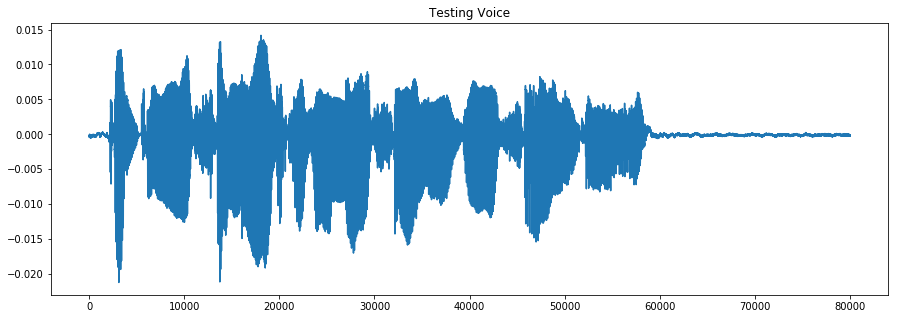

In [16]:
sentence1 = sio.loadmat('Data/%s/sentence1.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence1, 0)

-522.958132397684 187


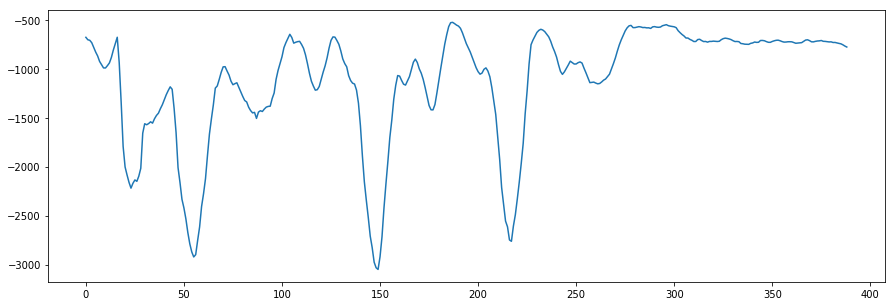

In [17]:
window_size = 10
log = []

for f_i in range(0, len(feature_stn_te)-window_size):
    score = model_vowel.score_samples(feature_stn_te[range(f_i, f_i+window_size)])
    log.append(score[0])

plt.figure(figsize=(15,5))
plt.plot(log)
print(max(log), np.argmax(log))

##### Sentence 2
“Only w**e fee**l you d**o fai**l in n**ew fa**llen dew”

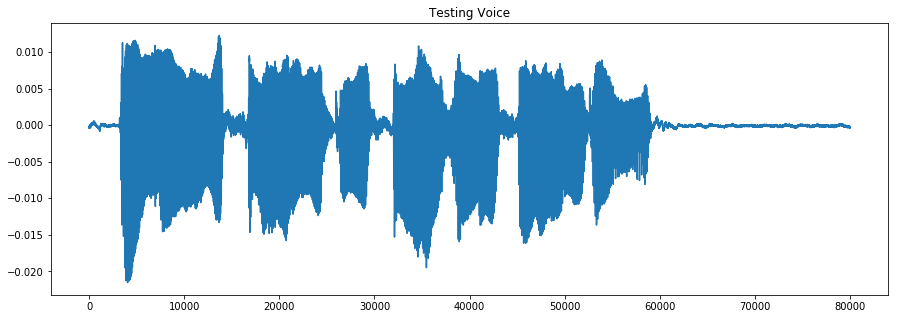

In [18]:
sentence2 = sio.loadmat('Data/%s/sentence2.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence2, 0)

-484.13414898224516 291


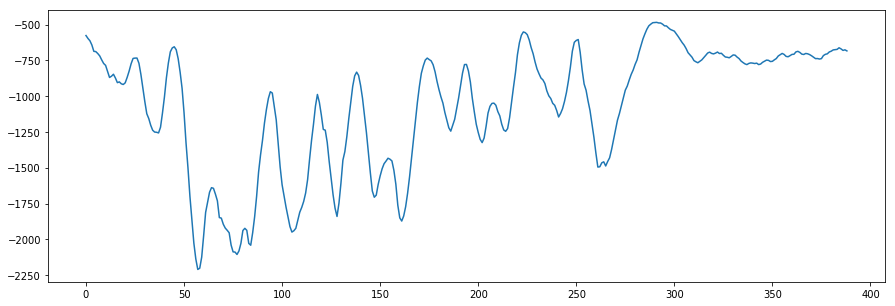

In [20]:
window_size = 10
log = []

for f_i in range(0, len(feature_stn_te)-window_size):
    score = model_vowel.score_samples(feature_stn_te[range(f_i, f_i+window_size)])
    log.append(score[0])

plt.figure(figsize=(15,5))
plt.plot(log)
print(max(log), np.argmax(log))